In [1]:
import os
import pandas as pd
import numpy as np
from pyInfinityFlow.InfinityFlow_Utilities import read_fcs_into_anndata
from pyInfinityFlow.InfinityFlow_Utilities import apply_logicle_to_anndata
from pyInfinityFlow.InfinityFlow_Utilities import pearson_corr_df_to_df
from pyInfinityFlow.InfinityFlow_Utilities import anndata_to_df
from pyInfinityFlow.fcs_io import FCSFileObject
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from adjustText import adjust_text

from pyInfinityFlow.Plotting_Utilities import assign_rainbow_colors_to_groups

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2022_12_07_new_multilin_panel/")

In [2]:
# Read in the UMAP coordinates
path_umap_coors = "output/automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "umap_2d_coordinates_redo.csv"

umap_anno = pd.read_csv(path_umap_coors, index_col=0)


# Read in R7 cluster assignments
path_r7_labels = "output/automated_py3_cellharmony_r7/"\
    "r7_py3_cellharmony_assigned_infinity_flow_groups_redo.csv"

r7_labels = pd.read_csv(path_r7_labels, index_col=0)

umap_anno["R7"] = r7_labels.loc[umap_anno.index.values, "r7"].values

umap_anno

umap-x     umap-y              R7
cell_id                                       
:0        10.952296  -6.878245    preNeu-3-ADT
:1        10.202045   7.717799  pre-MultiLin-1
:2        12.240065  -3.202506        preNeu-1
:3         6.748181  21.352978     pre-B-Il2ra
:4         9.314702   5.906703        ETP-CC-4
...             ...        ...             ...
:1935032  -4.400203  -1.029844    ERP4-Bcl2l15
:1935033  12.978972  -5.007983        preNeu-1
:1935034  10.876128   5.335987      MultiLin-1
:1935035   5.310091  -2.056845            Baso
:1935036  14.387283   6.744263        MDP-Irf8

[1935037 rows x 3 columns]

In [3]:
# Read in evenly sampled cells for background
even_sampled_cells = pd.read_csv("/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/analysis/2022_12_07_new_multilin_panel/output/"\
    "automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "list_evenly_sampled_cells_redo.csv", header=None).iloc[:,0]

even_sampled_cells

0           :1530
1           :3945
2           :8052
3           :8120
4          :10035
           ...   
99995    :1813998
99996     :838366
99997     :344154
99998     :836533
99999       :7039
Name: 0, Length: 100000, dtype: object

In [4]:
### Read in the InfinityFlow data
# Thresholds for scaling
min_max_thresh = pd.read_csv("output/cite_inflow_integration_input/"\
    "inflow_rescaling_thresholds.csv", index_col=0).T

min_max_thresh.columns = ["min", "max"]
min_max_thresh.head()

# Note the mapping of old infinityflow to new panel was redone, but the transfer
# to cite-seq distributions currently uses the old mapping
tmp_fcs = read_fcs_into_anndata("output/infinity_flow/infinity_flow_reprediction_on_new_panal_logicle_redo.fcs")

print("Applying logicle normalization...")
apply_logicle_to_anndata(tmp_fcs)

# print("Rescaling features to remove outliers...")
# rescaled = {}
# for tmp_channel in min_max_thresh.index.values:
#     input_array = tmp_fcs[:,tmp_channel].X.toarray().reshape(-1)
#     rescaled[tmp_channel] = map_min_max(\
#         input_array,
#         min_max_thresh.loc[tmp_channel, "min"],
#         min_max_thresh.loc[tmp_channel, "max"])
    
# rescaled = pd.DataFrame(rescaled)

# inflow_data = pd.DataFrame(\
#     rescaled[links_adt["Channel"].values].values,
#     columns=links_adt.index,
#     index=tmp_fcs.obs.index.values)

# del tmp_fcs
# gc.collect()

# # Fix na values in fcs data
# print("Remove indices with NaN values:\n")
# print(inflow_data.loc[inflow_data.isna().sum(axis=1) > 0].index.values)
# inflow_data = inflow_data.loc[~(inflow_data.isna().sum(axis=1) > 0)]

# # DataFrames for anndata objects
# var_df = pd.DataFrame(\
#     {"name": inflow_data.columns.values}, 
#     index=inflow_data.columns.values)

Applying logicle normalization...


In [5]:
### Reading in the data from CITE-seq
## RNA
path_rna_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2022_07_07_tea_seq_atac_processing/"
adata_cite = anndata.read_h5ad(os.path.join(path_rna_data,
    "input/teaseq_pyharmony_knn_label_transfer/"\
    "cite_seq_adata_rna_combined.h5ad"))
print("Computing CPTT normalized scRNA-seq from CITE-seq...")
adata_cite.X = np.log2((10000 * (adata_cite.X.T / \
    adata_cite.X.sum(axis=1).T).T) + 1)
cite_cell_anno = pd.read_csv(os.path.join(path_rna_data,
    "input/teaseq_pyharmony_knn_label_transfer/"\
    "cite_seq_cell_annotations.csv"))
cite_cell_anno.index = cite_cell_anno["Cell_Barcode"].values

# Fix obs to match cell indexing naming scheme
adata_cite.obs["old_name"] = adata_cite.obs.index.values
adata_cite.obs["barcode"] = [i.split("_")[-1] for i in \
    adata_cite.obs.index.values]
adata_cite.obs["sample"] = ["_".join(i.split("_")[:-1]) for i in \
    adata_cite.obs.index.values]
replace_port_names = {\
    "AS_CITE_ML1": "AS_CITE_Multilin1",
    "AS_CITE_ML2": "AS_CITE_Multilin2"}
adata_cite.obs["sample"] = adata_cite.obs["sample"].replace(\
    replace_port_names).values
adata_cite.obs.index = (adata_cite.obs["barcode"] + "." + \
    adata_cite.obs["sample"]).values

# # Make pseudobulk RNA counts from cite clusters
# print("Computing RNA centroids...")
# shared_cells_cite = np.intersect1d(cite_cell_anno.index.values, 
#     adata_cite.obs.index.values)
# cite_cell_anno = cite_cell_anno.loc[shared_cells_cite]
# cite_rna = {}
# for tmp_cluster in cite_cell_anno["sctri_cite"].unique():
#     print("\t{}...".format(tmp_cluster))
#     tmp_barcodes = cite_cell_anno.loc[\
#         cite_cell_anno["sctri_cite"] == tmp_cluster].index.values
#     cite_rna[tmp_cluster] = pd.Series(np.asarray(\
#             adata_cite[tmp_barcodes].X.mean(axis=0)).reshape(-1),
# 		index=adata_cite.var.index.values)

# cite_rna = pd.DataFrame(cite_rna)
# cite_rna = cite_rna.drop("Unknown", axis=1)
# map_r7_names = pd.read_csv(os.path.join(path_rna_data,
#     "input/map_r7-v1_to_r7-v2_names.csv"), 
#     index_col=0).iloc[:,0]
# cite_rna.columns = np.array([map_r7_names[item] for item in \
#     cite_rna.columns.values])

Computing CPTT normalized scRNA-seq from CITE-seq...


In [6]:
# Read in the mapping of cite-seq cells to infinityflow neighbors
cite_nn_to_inflow = pd.read_csv("output/automated_py3_cellharmony_r7/"\
    "evenly_sampled_r7/mapped_cite_into_inflow_umap/"\
    "mapped_cite_4nn_inflow_indices_annotation.csv",
    index_col=0)

cite_nn_to_inflow

nn_indices
cell_id                                                              
AAACCCAAGACCCTTA-1.AS_3CITE_Kitx2  :1009619|:138024|:1329782|:1234819
AAACCCAAGACTCCGC-1.AS_3CITE_Kitx2  :1933392|:1902492|:1879205|:562150
AAACCCAAGATAGCTA-1.AS_CITE_Kit         :79659|:1925572|:99614|:927877
AAACCCAAGATGATTG-1.AS_CITE_Kit     :1883841|:365085|:1902103|:1332936
AAACCCAAGGATTTGA-1.AS_CITE_Kit      :1890336|:765512|:786158|:1701085
...                                                               ...
TTTGTTGTCAAGGTGG-1.AS_CITE_CD127    :1287845|:847915|:1925572|:371799
TTTGTTGTCCAACTGA-1.AS_CITE_CD127     :111234|:1289591|:853351|:292926
TTTGTTGTCCTTTGAT-1.AS_CITE_CD127   :917158|:1019450|:1617496|:1767799
TTTGTTGTCTTCGTGC-1.AS_CITE_HSC       :75506|:1364331|:1905535|:524480
TTTGTTGTCTTGGAAC-1.AS_CITE_CD127     :519422|:1020381|:374077|:710751

[57728 rows x 1 columns]

In [7]:
# Read in the CITE-seq positions
cite_umap = pd.read_csv("output/automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "mapped_cite_into_inflow_umap/mapped_cite_4nn_umap_and_dist_annotation.csv",
    index_col=0)

cite_groups = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_r7_all_cells.csv")
cite_groups.index = cite_groups["cell"]

# Attach umap to annotation dataframe
cite_groups.loc[:,["umap-x", "umap-y"]] = cite_umap.loc[\
    cite_groups.index.values,["umap-x", "umap-y"]].values

cite_groups

cell  umi_adt  \
cell                                                                      
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC  TTGTTTGTCCGTGGTG-1.AS_CITE_HSC      508   
TTTGGTTTCGCCTATC-1.AS_CITE_HSC  TTTGGTTTCGCCTATC-1.AS_CITE_HSC      512   
GAGTTTGGTGCTGATT-1.AS_CITE_HSC  GAGTTTGGTGCTGATT-1.AS_CITE_HSC      548   
GCTACAAGTTAGAAAC-1.AS_CITE_HSC  GCTACAAGTTAGAAAC-1.AS_CITE_HSC      548   
TTACCGCGTATGCAAA-1.AS_CITE_HSC  TTACCGCGTATGCAAA-1.AS_CITE_HSC      585   
...                                                        ...      ...   
TTGCGTCCAGTTAAAG-1.AS_CITE_HSC  TTGCGTCCAGTTAAAG-1.AS_CITE_HSC     1937   
AATGAAGGTTGCCGCA-1.AS_CITE_HSC  AATGAAGGTTGCCGCA-1.AS_CITE_HSC     1972   
AAGACTCGTAATCAGA-1.AS_CITE_HSC  AAGACTCGTAATCAGA-1.AS_CITE_HSC     1973   
TCGGTCTAGACCATTC-1.AS_CITE_HSC  TCGGTCTAGACCATTC-1.AS_CITE_HSC     1975   
TACTTCATCCTATTGT-1.AS_CITE_HSC  TACTTCATCCTATTGT-1.AS_CITE_HSC     1978   

                                       port       cluster ari_group    umap-x  \
cell                                                                            
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC  AS_CITE_HSC  LT-HSC_Mllt3      HSCP  4.843840   
TTTGGTTTCGCCTATC-1.AS_CITE_HSC  AS_CITE_HSC  LT-HSC_Mllt3       NaN  3.264343   
GAGTTTGGTGCTGATT-1.AS_CITE_HSC  AS_CITE_HSC  LT-HSC_Mllt3       NaN  3.046479   
GCTACAAGTTAGAAAC-1.AS_CITE_HSC  AS_CITE_HSC  LT-HSC_Mllt3      HSCP  3.174582   
TTACCGCGTATGCAAA-1.AS_CITE_HSC  AS_CITE_HSC  LT-HSC_Mllt3      HSCP  2.561091   
...                                     ...           ...       ...       ...   
TTGCGTCCAGTTAAAG-1.AS_CITE_HSC  AS_CITE_HSC  HSC-Mac_Fcna       NaN  1.063439   
AATGAAGGTTGCCGCA-1.AS_CITE_HSC  AS_CITE_HSC  HSC-Mac_Fcna       NaN  1.210337   
AAGACTCGTAATCAGA-1.AS_CITE_HSC  AS_CITE_HSC  HSC-Mac_Fcna       NaN  5.136513   
TCGGTCTAGACCATTC-1.AS_CITE_HSC  AS_CITE_HSC  HSC-Mac_Fcna       NaN  0.919061   
TACTTCATCCTATTGT-1.AS_CITE_HSC  AS_CITE_HSC  HSC-Mac_Fcna       NaN -0.460581   

                                   umap-y  
cell                                       
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC   8.671780  
TTTGGTTTCGCCTATC-1.AS_CITE_HSC   8.094186  
GAGTTTGGTGCTGATT-1.AS_CITE_HSC   8.398525  
GCTACAAGTTAGAAAC-1.AS_CITE_HSC   8.241629  
TTACCGCGTATGCAAA-1.AS_CITE_HSC   8.506154  
...                                   ...  
TTGCGTCCAGTTAAAG-1.AS_CITE_HSC   1.520592  
AATGAAGGTTGCCGCA-1.AS_CITE_HSC   1.582764  
AAGACTCGTAATCAGA-1.AS_CITE_HSC  11.191032  
TCGGTCTAGACCATTC-1.AS_CITE_HSC   1.720564  
TACTTCATCCTATTGT-1.AS_CITE_HSC  -1.186589  

[55403 rows x 7 columns]

In [8]:
def helper_plot_marker_over_umap(marker_name, exp_vector, umap_1, umap_2, 
        plot_title, point_size=1, path_output=""):
    # Sort input based on values
    tmp_sort_df = pd.DataFrame({\
        "exp_vector": exp_vector,
        "umap_1": umap_1,
        "umap_2": umap_2})
    tmp_sort_df = tmp_sort_df.sort_values(by="exp_vector")
    # Set up figure
    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot()
    # Plot scatter plot
    ax.scatter(\
        tmp_sort_df["umap_1"].values,
        tmp_sort_df["umap_2"].values,
        c=tmp_sort_df["exp_vector"].values,
        cmap="Reds", 
        s=point_size, 
        alpha=1)
    # Adjust visualization around figure
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_figwidth(16)
    fig.set_figheight(16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    fig.suptitle(plot_title, fontsize=20)
    if path_output == "":
        plt.show()
    else:
        plt.savefig(path_output, dpi=300)

def normalize_signal_for_plotting_mrna_counts(input_vector, ptilemin=5, 
        ptilemax=95):
    input_vector = input_vector.copy()
    tmp_min = np.percentile(input_vector, ptilemin)
    tmp_max = np.percentile(input_vector, ptilemax)
    input_vector[input_vector <= tmp_min] = tmp_min
    input_vector[input_vector >= tmp_max] = tmp_max
    return(input_vector)


In [9]:
# Read in the data provided by Nathah for the reference
"""
He was unhappy after initial meeting upon seeing these plots, because he thought
the scatterplots when he projected the RNA data was smoother. After investigating
it a little bit, it was apparent the color scale was causing this confusion.

He suggested to try to use the "Reds" color scale, instead of the "jet" color 
scale, to better hide the noisy 0 values.

He also thought I was working with fewer cells than he had...
"""

nathan_groups = pd.read_table(\
    "input/cite_seq_data/soupx_data_for_reporters_integration/groups.R7.1-temp-names.txt",
    header=None)

nathan_umap = pd.read_table(\
    "input/cite_seq_data/soupx_data_for_reporters_integration/UMAP_CITE_HIVE-coords-filtered.txt",
    header=None, index_col=0)
nathan_umap.columns = ["umap-x", "umap-y"]

nathan_exp = pd.read_table(\
    "input/cite_seq_data/soupx_data_for_reporters_integration/exp.R7.1-temp-names.txt",
    index_col=0).T

In [10]:
nathan_umap

umap-x    umap-y
0                                                  
CGAATTGAGACTCAAA-1.AS_CITE_HSC -11.459088 -1.606385
TCGGATAGTGTCACAT-1.AS_CITE_HSC -11.951331 -1.433558
CAGATCATCCGATGCG-1.AS_CITE_HSC -11.529243 -0.945597
CCTCTAGTCATAAGGA-1.AS_CITE_HSC -11.755588 -1.199329
TGAGTCAGTGCTATTG-1.AS_CITE_HSC -11.268518 -0.733500
...                                   ...       ...
AATCGTGCACGCGGTT-1.AS_CITE_Kit   2.417125  8.480896
TCCTGCAGTAGGACTG-1.AS_CITE_Kit   2.523078  8.694991
TCGTAGAGTGGGCTCT-1.AS_CITE_Kit   2.635684  9.101950
CATCCGTTCATCTGTT-1.AS_CITE_Kit   2.178841 -4.465740
ACTTCGCGTCTGCAAT-1.AS_CITE_Kit   2.183568  8.355062

[63251 rows x 2 columns]

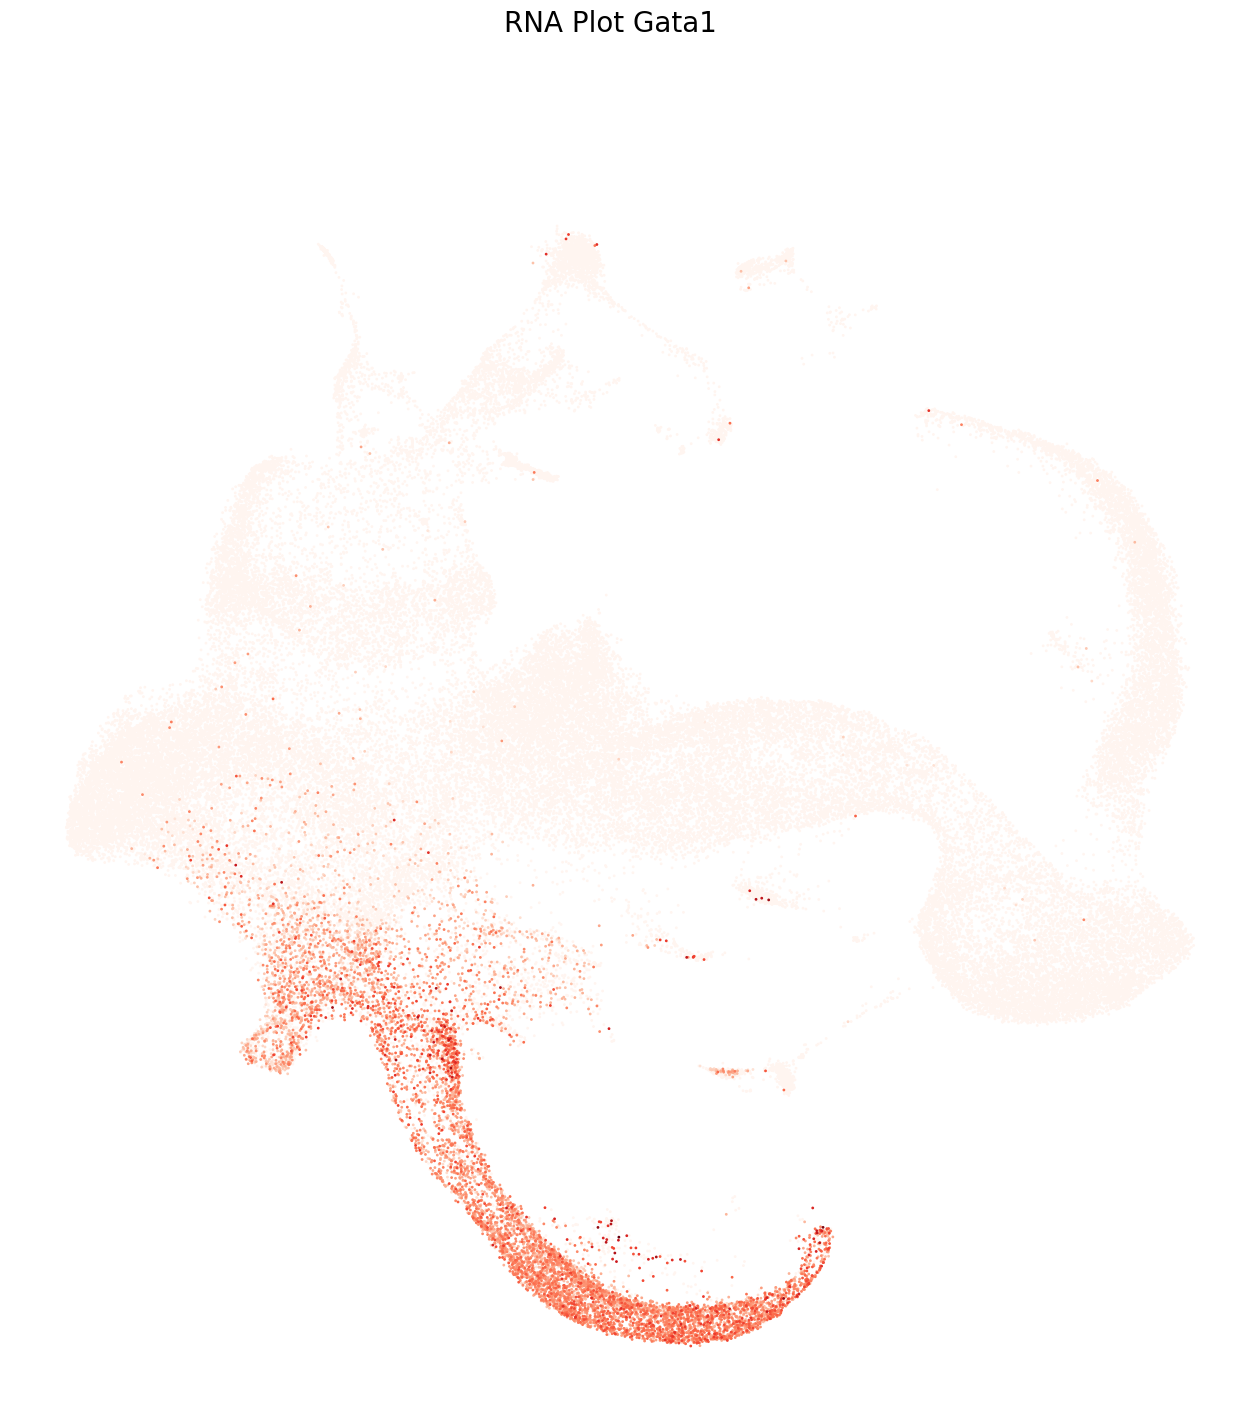

In [11]:
helper_plot_marker_over_umap(\
    marker_name="Gata1", 
    exp_vector=nathan_exp["Gata1"].values, 
    umap_1=nathan_umap.loc[nathan_exp.index.values,"umap-x"].values, 
    umap_2=nathan_umap.loc[nathan_exp.index.values,"umap-y"].values, 
    point_size=1,
    plot_title="RNA Plot Gata1")

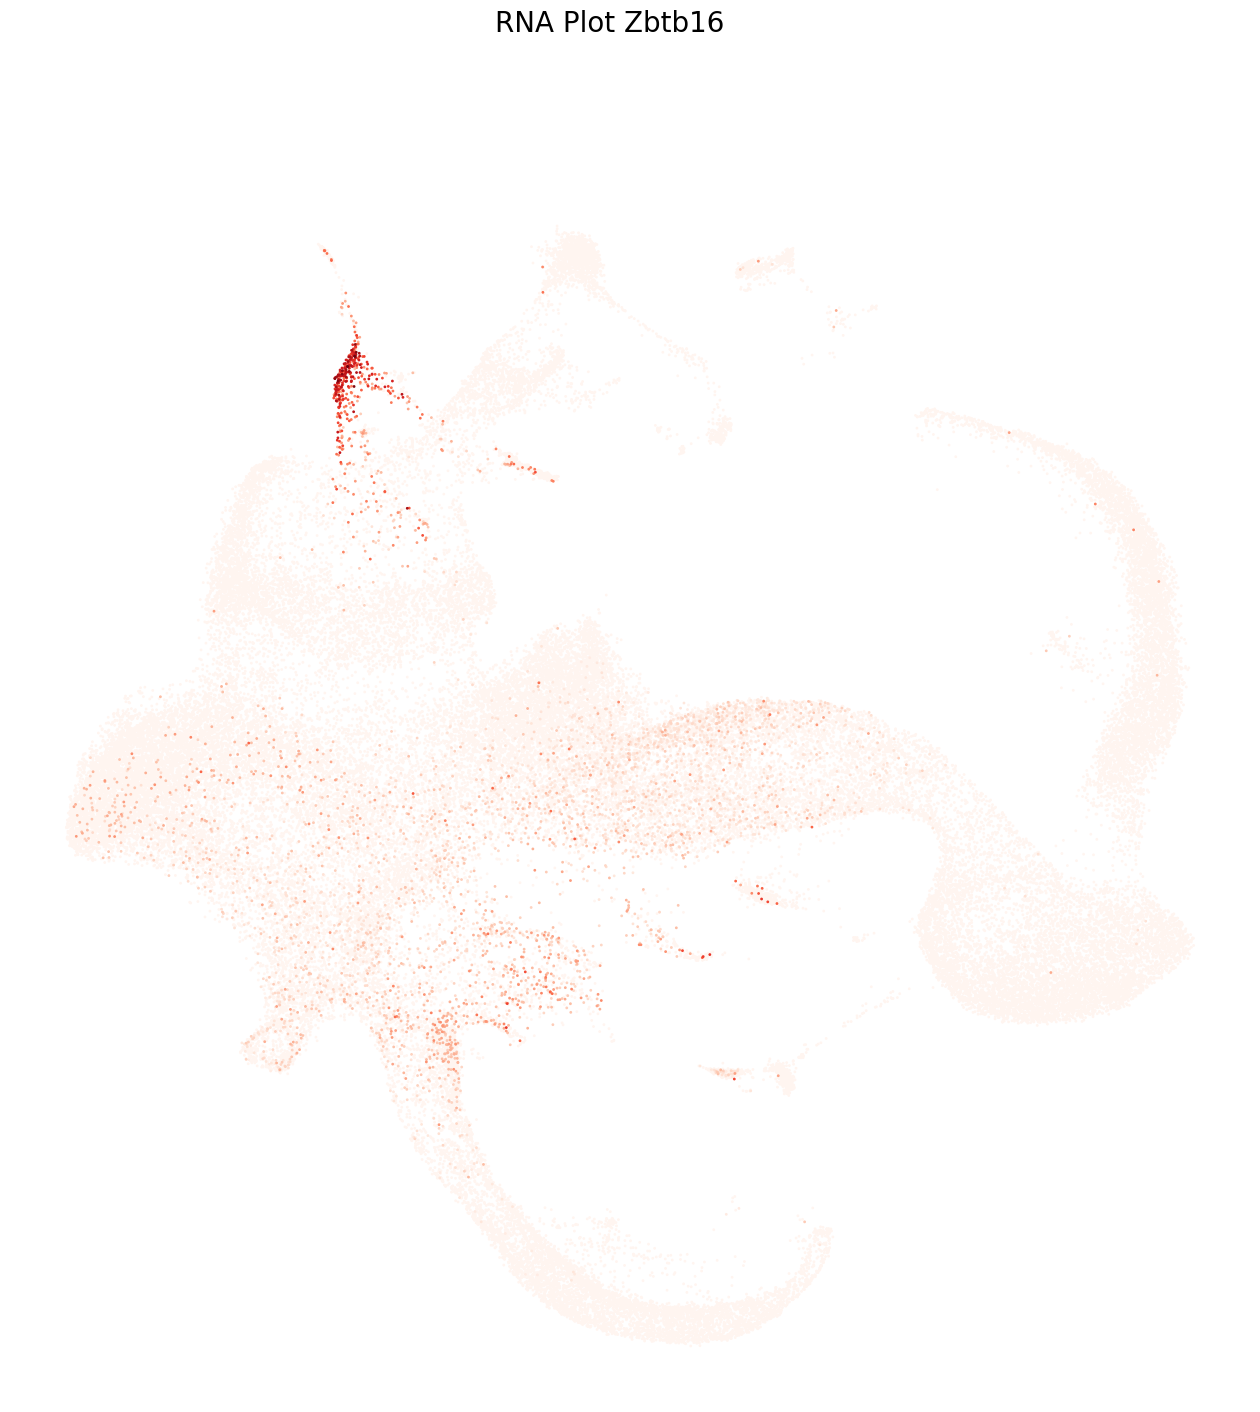

In [21]:
helper_plot_marker_over_umap(\
    marker_name="Zbtb16", 
    exp_vector=nathan_exp["Zbtb16"].values, 
    umap_1=nathan_umap.loc[nathan_exp.index.values,"umap-x"].values, 
    umap_2=nathan_umap.loc[nathan_exp.index.values,"umap-y"].values, 
    point_size=1,
    plot_title="RNA Plot Zbtb16")

In [12]:
nathan_exp

UID                                 Spi1  Gata1      Phf6       Tox      Gfi1  \
CGAATTGAGACTCAAA-1.AS_CITE_HSC  0.906483    0.0  0.000000  0.000000  0.000000   
TCGGATAGTGTCACAT-1.AS_CITE_HSC  0.667676    0.0  0.000000  0.667676  0.000000   
CAGATCATCCGATGCG-1.AS_CITE_HSC  0.000000    0.0  0.651927  0.651927  1.099316   
CCTCTAGTCATAAGGA-1.AS_CITE_HSC  0.000000    0.0  0.000000  0.604142  0.000000   
TGAGTCAGTGCTATTG-1.AS_CITE_HSC  0.626738    0.0  0.626738  1.062218  0.626738   
...                                  ...    ...       ...       ...       ...   
AATCGTGCACGCGGTT-1.AS_CITE_Kit  0.000000    0.0  0.000000  0.000000  0.000000   
TCCTGCAGTAGGACTG-1.AS_CITE_Kit  0.000000    0.0  2.684568  0.000000  0.000000   
TCGTAGAGTGGGCTCT-1.AS_CITE_Kit  0.000000    0.0  0.000000  0.000000  0.000000   
CATCCGTTCATCTGTT-1.AS_CITE_Kit  0.000000    0.0  0.000000  0.000000  0.000000   
ACTTCGCGTCTGCAAT-1.AS_CITE_Kit  0.000000    0.0  0.000000  0.000000  0.000000   

UID                                Gata2   Bhlhe40  Ncr1  Mki67      Irf8  \
CGAATTGAGACTCAAA-1.AS_CITE_HSC  2.303084  0.523296   0.0    0.0  0.000000   
TCGGATAGTGTCACAT-1.AS_CITE_HSC  1.979133  0.000000   0.0    0.0  0.000000   
CAGATCATCCGATGCG-1.AS_CITE_HSC  0.651927  0.000000   0.0    0.0  0.000000   
CCTCTAGTCATAAGGA-1.AS_CITE_HSC  0.604142  0.000000   0.0    0.0  0.000000   
TGAGTCAGTGCTATTG-1.AS_CITE_HSC  1.396274  0.000000   0.0    0.0  0.000000   
...                                  ...       ...   ...    ...       ...   
AATCGTGCACGCGGTT-1.AS_CITE_Kit  0.000000  0.000000   0.0    0.0  2.536817   
TCCTGCAGTAGGACTG-1.AS_CITE_Kit  0.000000  0.000000   0.0    0.0  0.000000   
TCGTAGAGTGGGCTCT-1.AS_CITE_Kit  0.000000  2.814551   0.0    0.0  0.000000   
CATCCGTTCATCTGTT-1.AS_CITE_Kit  0.000000  0.000000   0.0    0.0  0.000000   
ACTTCGCGTCTGCAAT-1.AS_CITE_Kit  0.000000  0.000000   0.0    0.0  2.650726   

UID                             Zbtb16  Tcf7       Myc  
CGAATTGAGACTCAAA-1.AS_CITE_HSC     0.0   0.0  1.671825  
TCGGATAGTGTCACAT-1.AS_CITE_HSC     0.0   0.0  0.000000  
CAGATCATCCGATGCG-1.AS_CITE_HSC     0.0   0.0  0.000000  
CCTCTAGTCATAAGGA-1.AS_CITE_HSC     0.0   0.0  1.028675  
TGAGTCAGTGCTATTG-1.AS_CITE_HSC     0.0   0.0  1.396274  
...                                ...   ...       ...  
AATCGTGCACGCGGTT-1.AS_CITE_Kit     0.0   0.0  0.000000  
TCCTGCAGTAGGACTG-1.AS_CITE_Kit     0.0   0.0  0.000000  
TCGTAGAGTGGGCTCT-1.AS_CITE_Kit     0.0   0.0  0.000000  
CATCCGTTCATCTGTT-1.AS_CITE_Kit     0.0   0.0  0.000000  
ACTTCGCGTCTGCAAT-1.AS_CITE_Kit     0.0   0.0  0.000000  

[63251 rows x 13 columns]

In [13]:
len(np.intersect1d(cite_groups.index.values, nathan_exp.index.values))

55285

In [14]:
path_out_plots = "output/automated_py3_cellharmony_r7/evenly_sampled_r7/"\
    "plots_for_pub/tf_reporters_inflow_citeseq_over_umap_plots_Reds_cmap/"

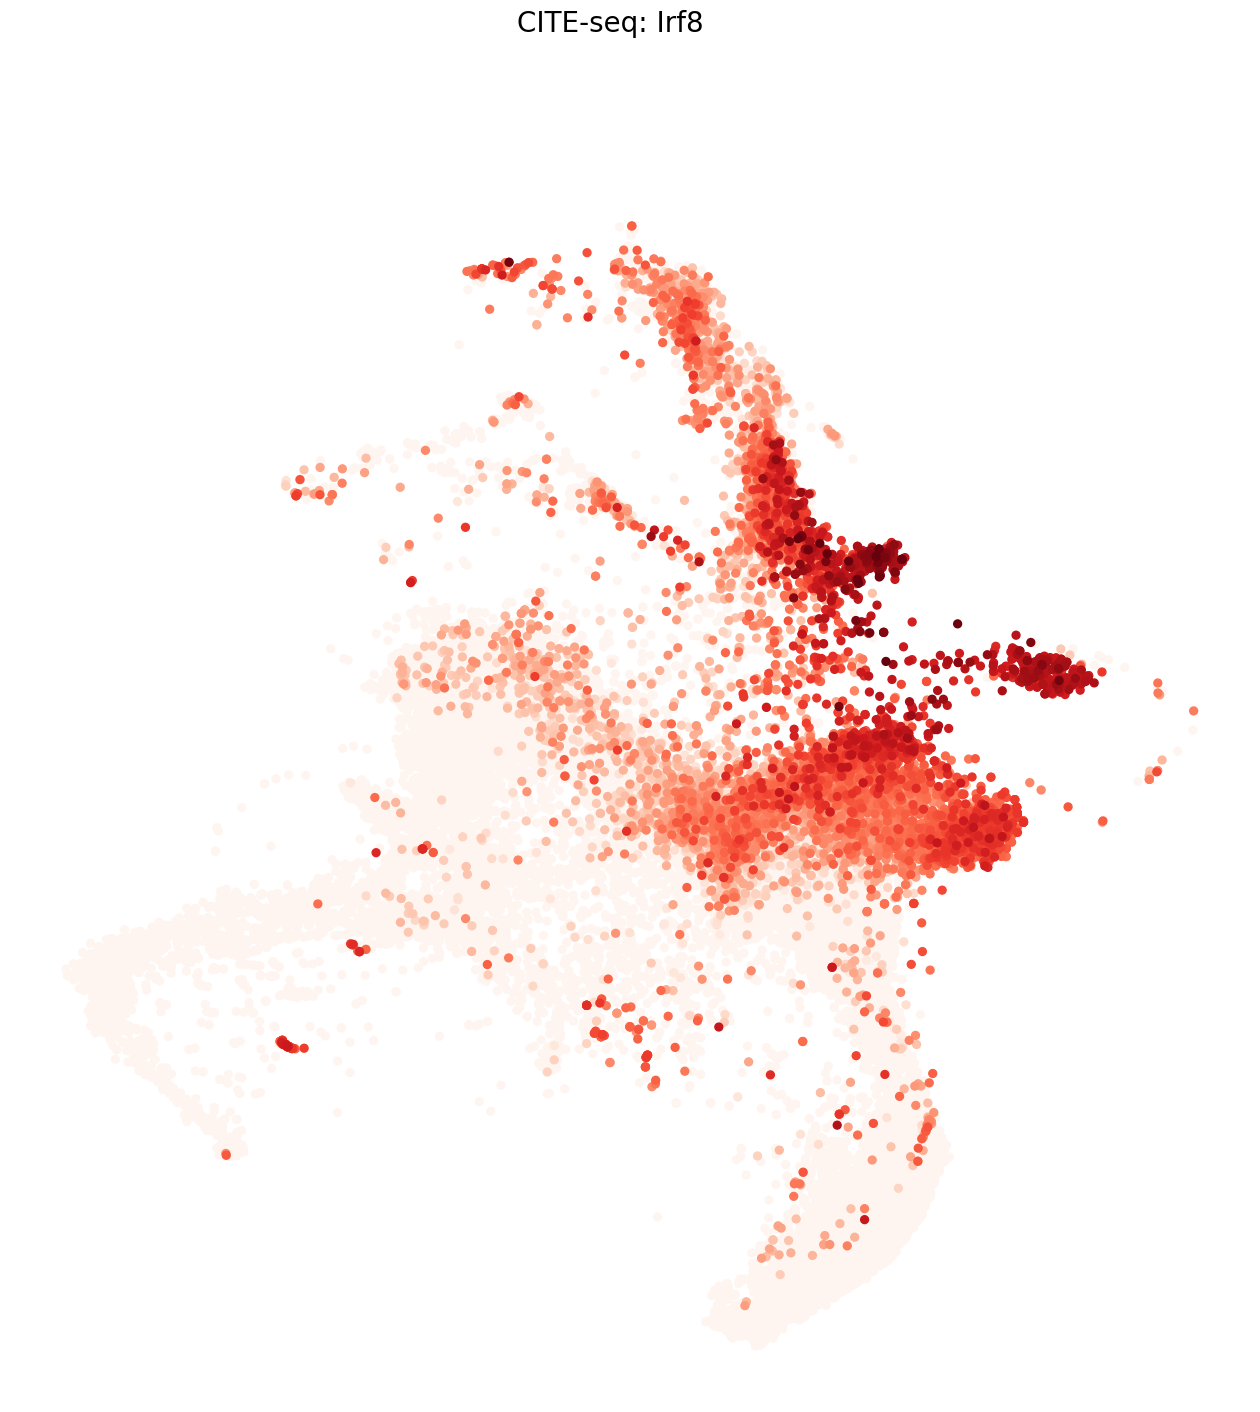

In [19]:
# Irf8
# helper_plot_marker_over_umap(\
#     marker_name="Irf8-GFP", 
#     exp_vector=tmp_fcs[\
#         even_sampled_cells.values, 
#         "GFP-A"].X.toarray().reshape(-1), 
#     umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
#     umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
#     point_size=1,
#     plot_title="Infinity Flow: Irf8-GFP", 
#     path_output=os.path.join(\
#         path_out_plots,
#         "InfinityFlow_Irf8-GFP_over_umap.png"))

shared_cells = np.intersect1d(cite_groups.index.values, nathan_exp.index.values)

helper_plot_marker_over_umap(\
    marker_name="Irf8", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(\
        nathan_exp.loc[\
            shared_cells, 
            "Irf8"].values,
        ptilemin=5, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[shared_cells,"umap-x"].values, 
    umap_2=cite_groups.loc[shared_cells,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Irf8")


# helper_plot_marker_over_umap(\
#     marker_name="Irf8", 
#     exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
#         cite_groups.index.values, 
#         "Irf8"].X.toarray().reshape(-1)), 
#     umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
#     umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
#     point_size=32,
#     plot_title="CITE-seq: Irf8", 
#     path_output=os.path.join(\
#         path_out_plots,
#         "CITE-seq_Irf8_over_umap.png"))

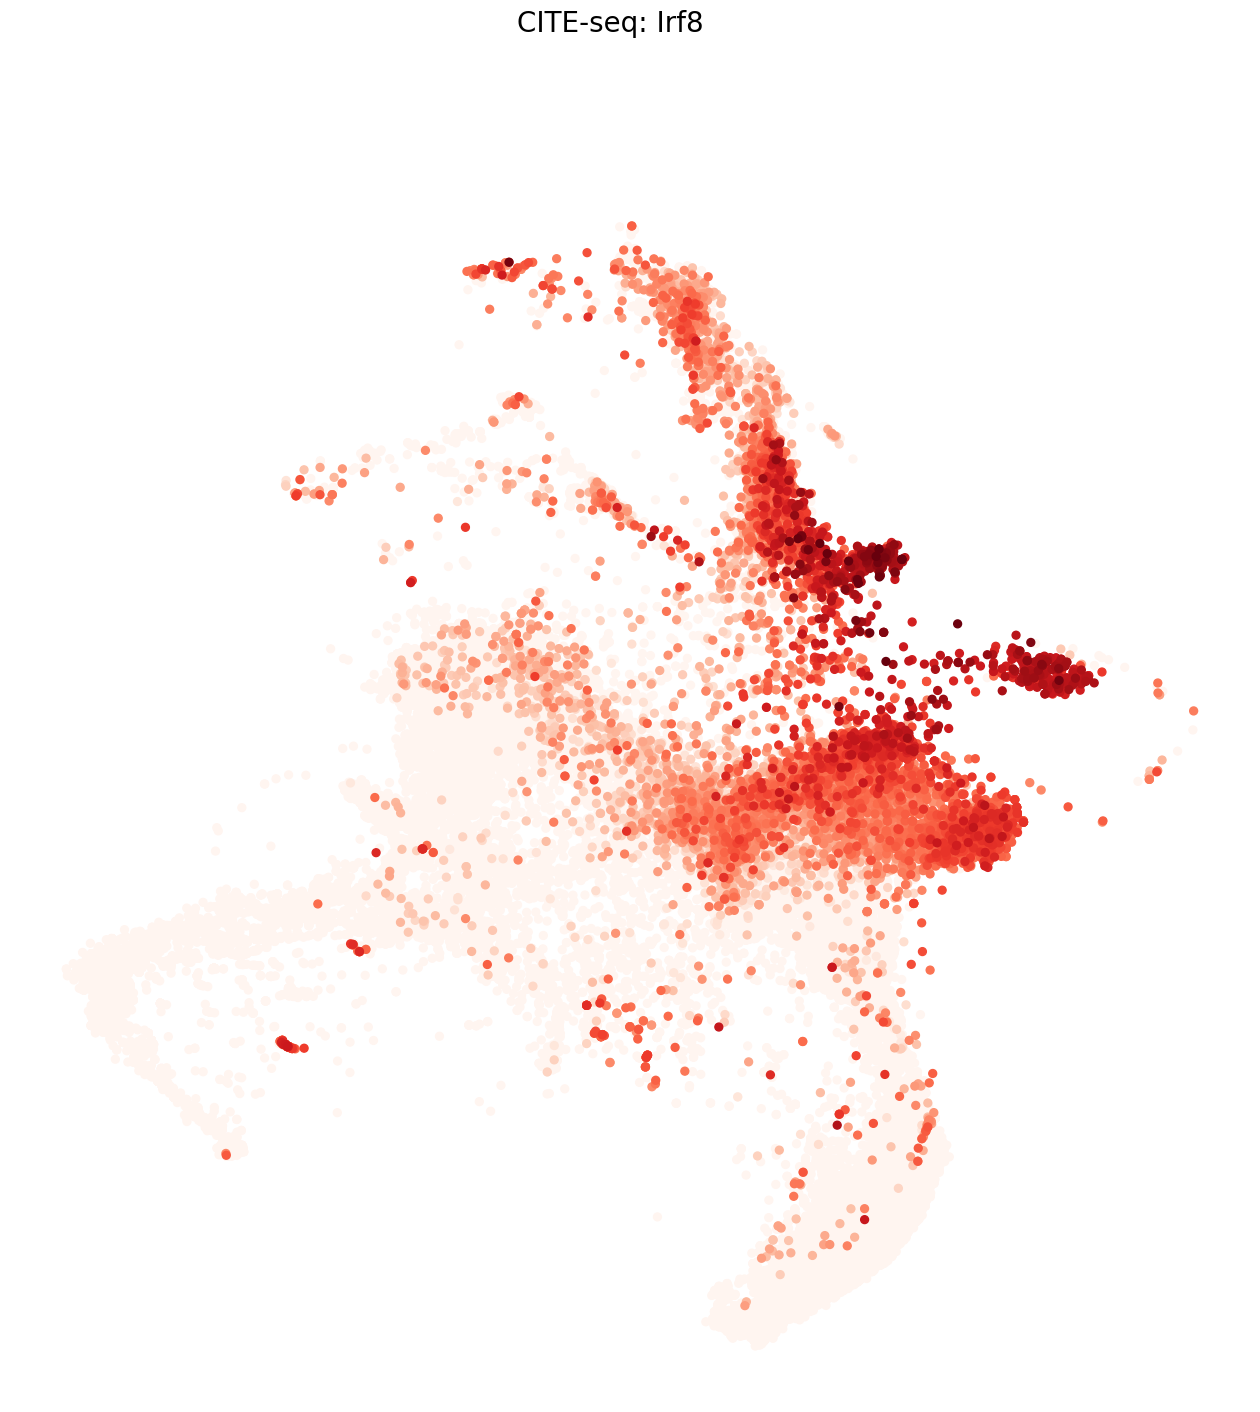

In [172]:
# Irf8
helper_plot_marker_over_umap(\
    marker_name="Irf8-GFP", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "GFP-A"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Irf8-GFP", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Irf8-GFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Irf8", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Irf8"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Irf8", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Irf8_over_umap.png"))

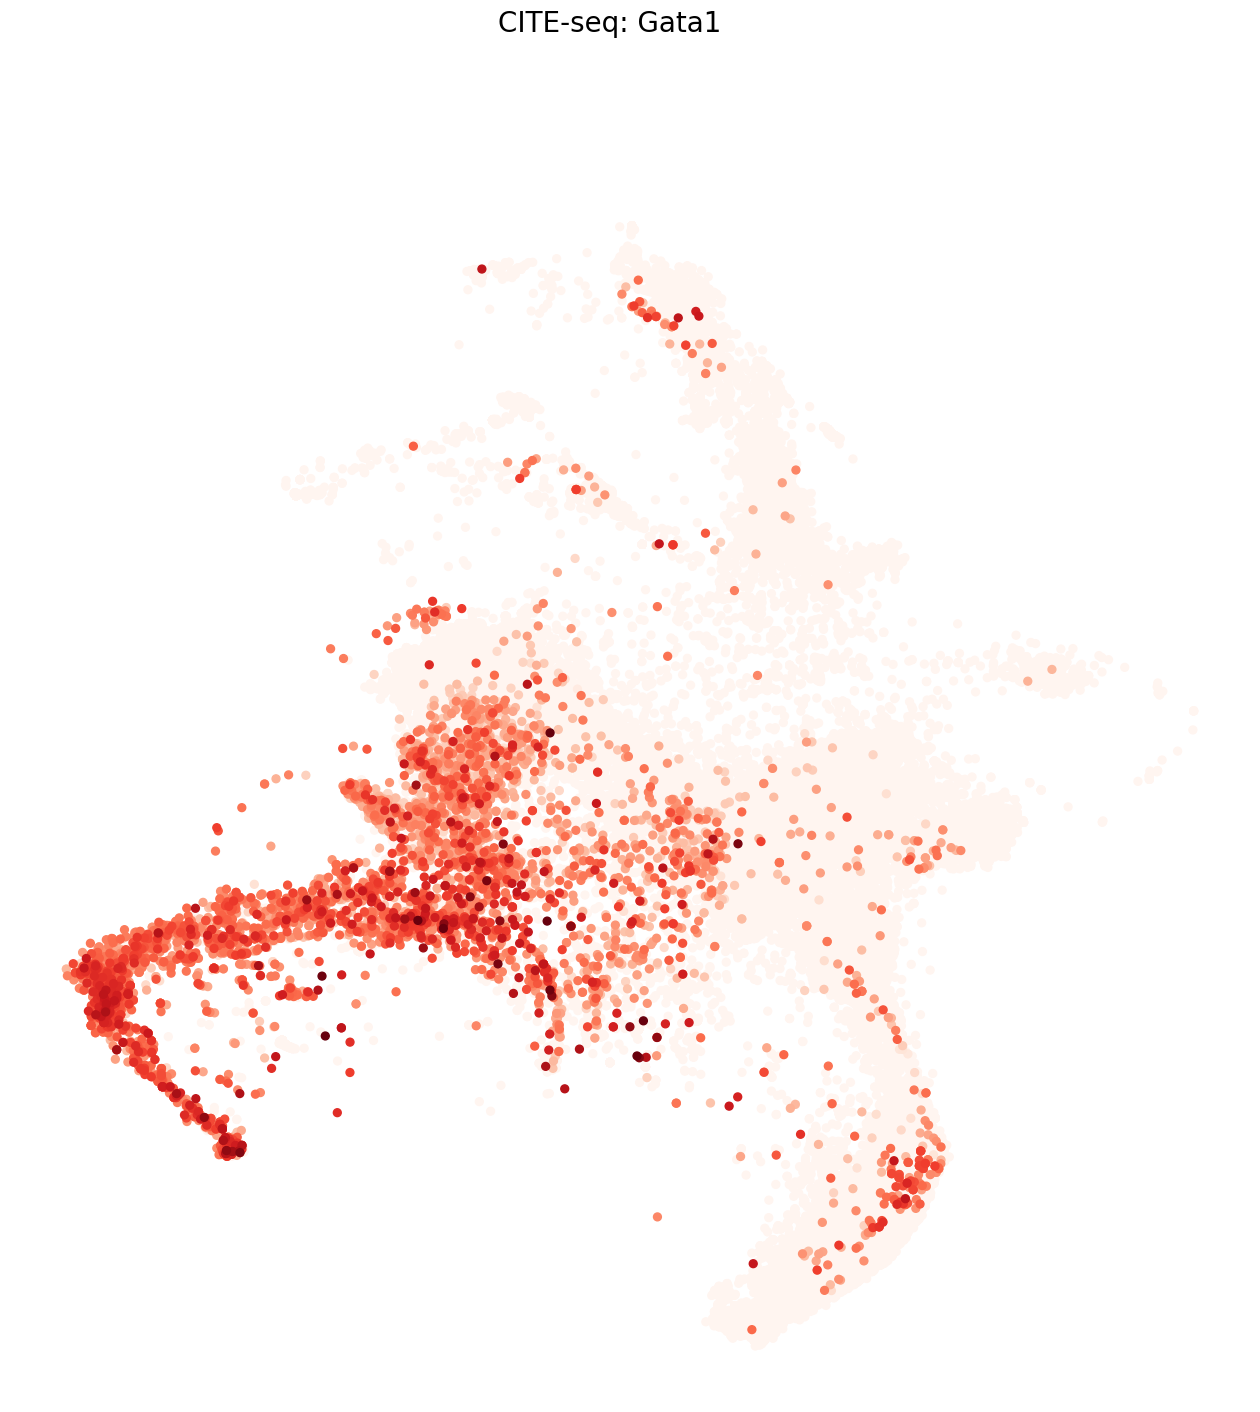

In [173]:
# Gata1
helper_plot_marker_over_umap(\
    marker_name="Gata1-mCherry", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Gata1-mCherry"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Gata1-mCherry", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Gata1-mCherry_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Gata1", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Gata1"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Gata1", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Gata1_over_umap.png"))

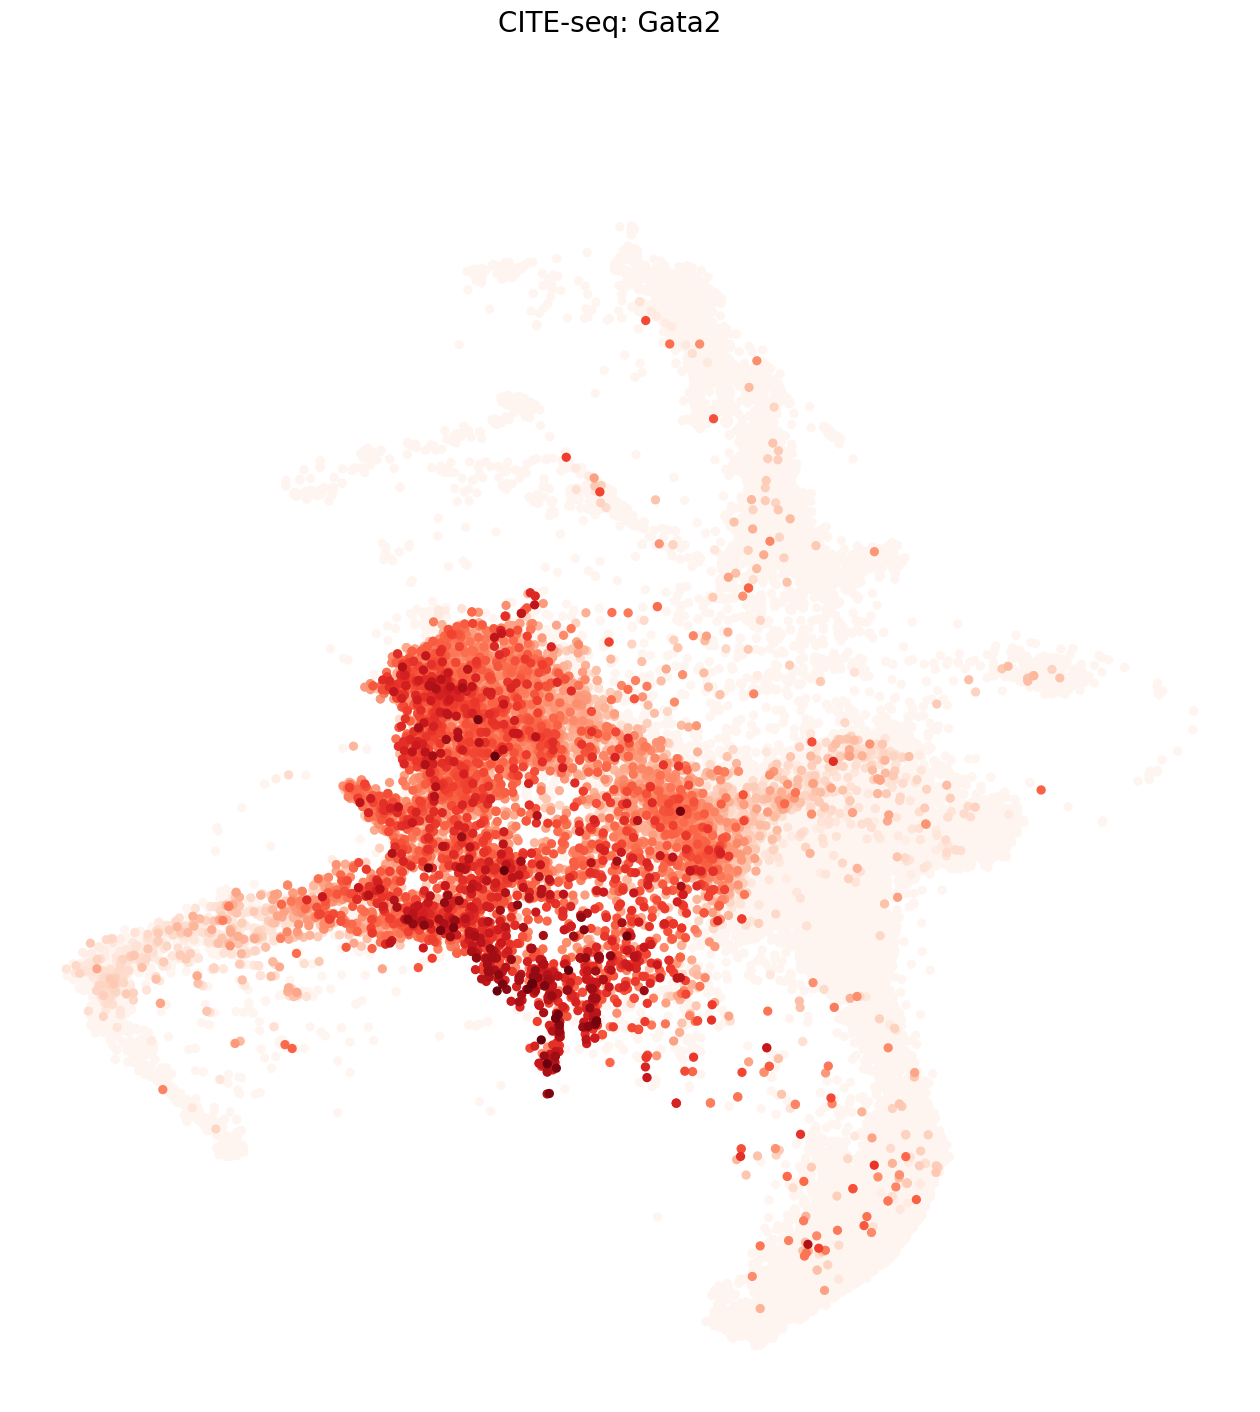

In [174]:
# Gata2
helper_plot_marker_over_umap(\
    marker_name="Gata2-Venus", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Gata2-Venus"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Gata2-Venus", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Gata2-Venus_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Gata2", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Gata2"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Gata2", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Gata2_over_umap.png"))

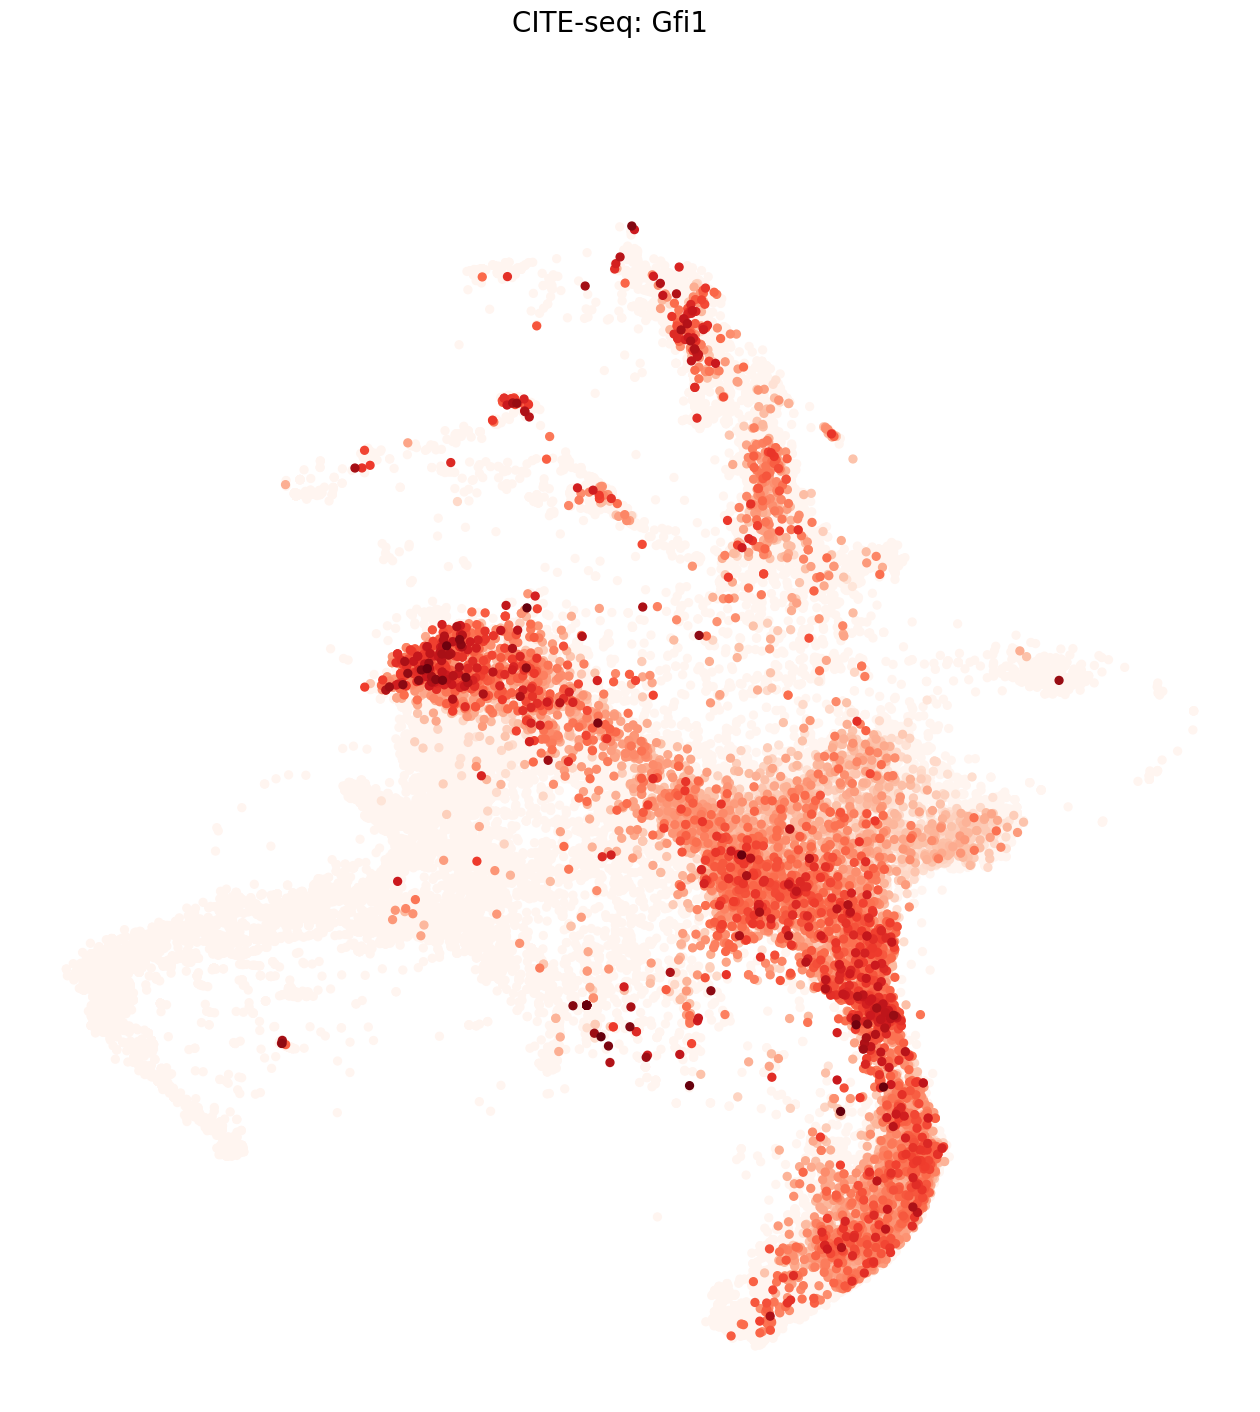

In [175]:
# Gfi1
helper_plot_marker_over_umap(\
    marker_name="Gfi1-tdTomato", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Gfi1-tdTomato"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Gfi1-tdTomato", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Gfi1-tdTomato_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Gfi1", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Gfi1"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Gfi1", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Gfi1_over_umap.png"))

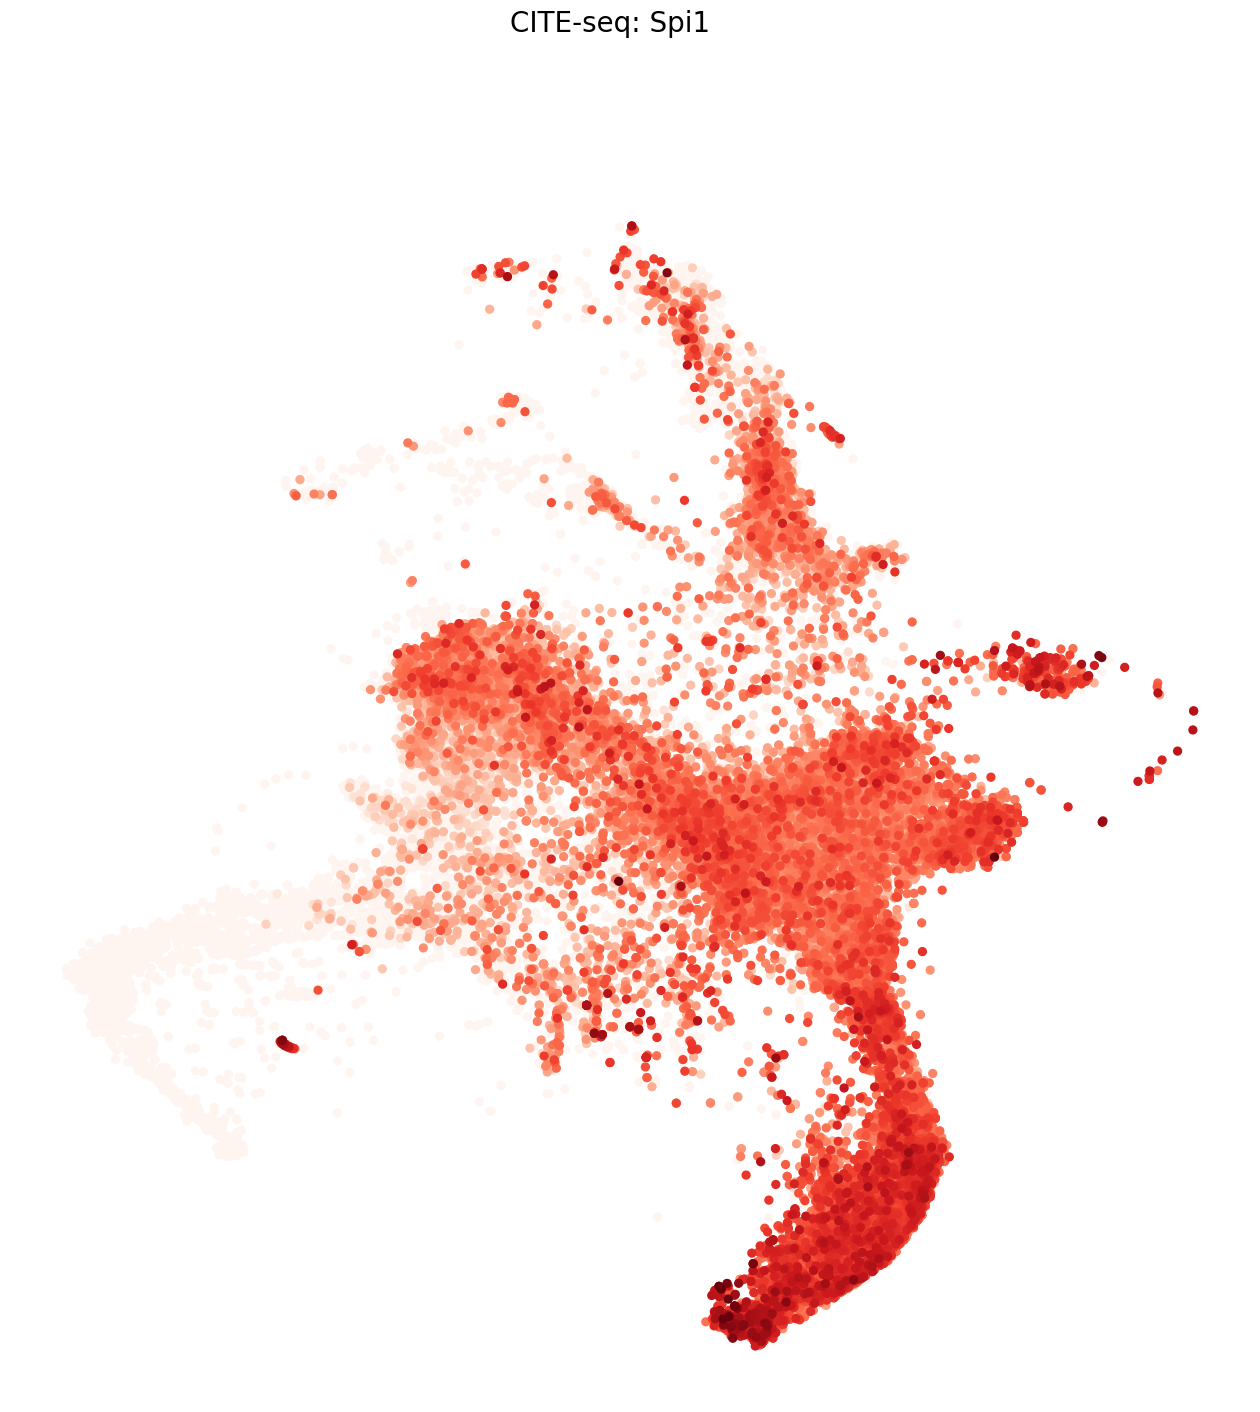

In [176]:
# Pu.1
helper_plot_marker_over_umap(\
    marker_name="Pu.1-YFP", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Pu.1-YFP"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Pu.1-YFP", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Pu.1-YFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Spi1", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Spi1"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Spi1", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Spi1_over_umap.png"))

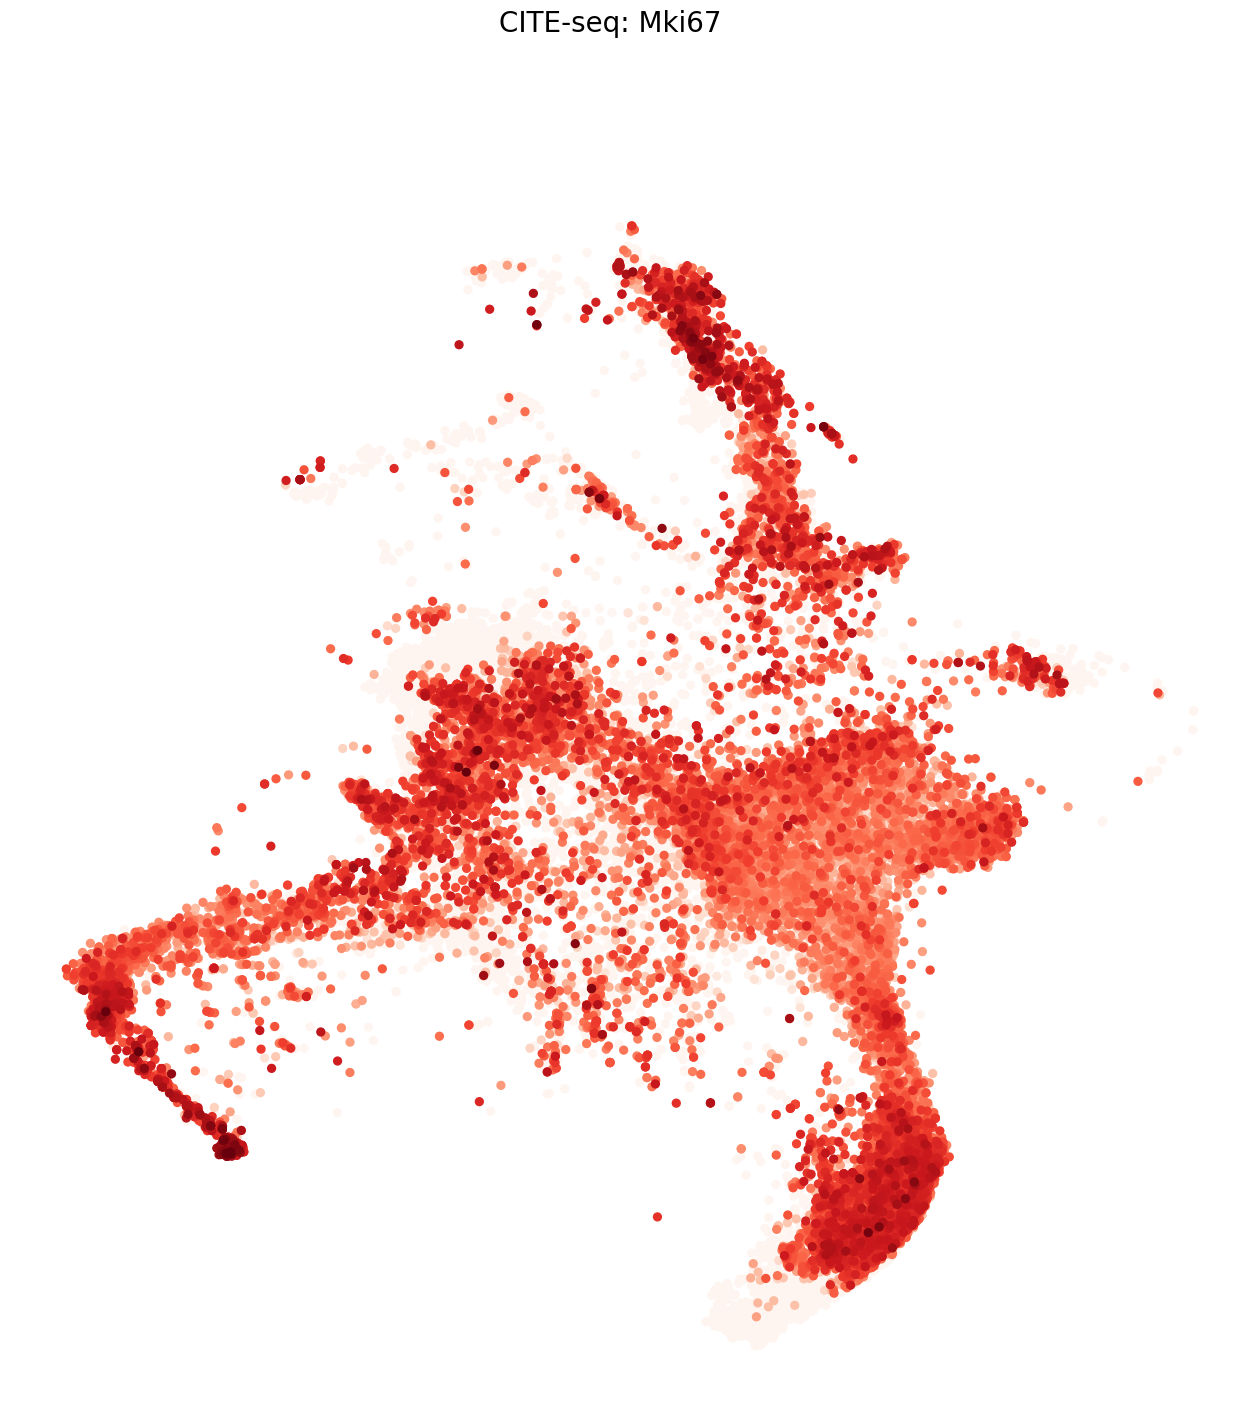

In [177]:
# Mki67-RFP
helper_plot_marker_over_umap(\
    marker_name="Mki67-RFP", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Mki67-RFP"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Mki67-RFP", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Mki67-RFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Mki67", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Mki67"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Mki67", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Mki67_over_umap.png"))

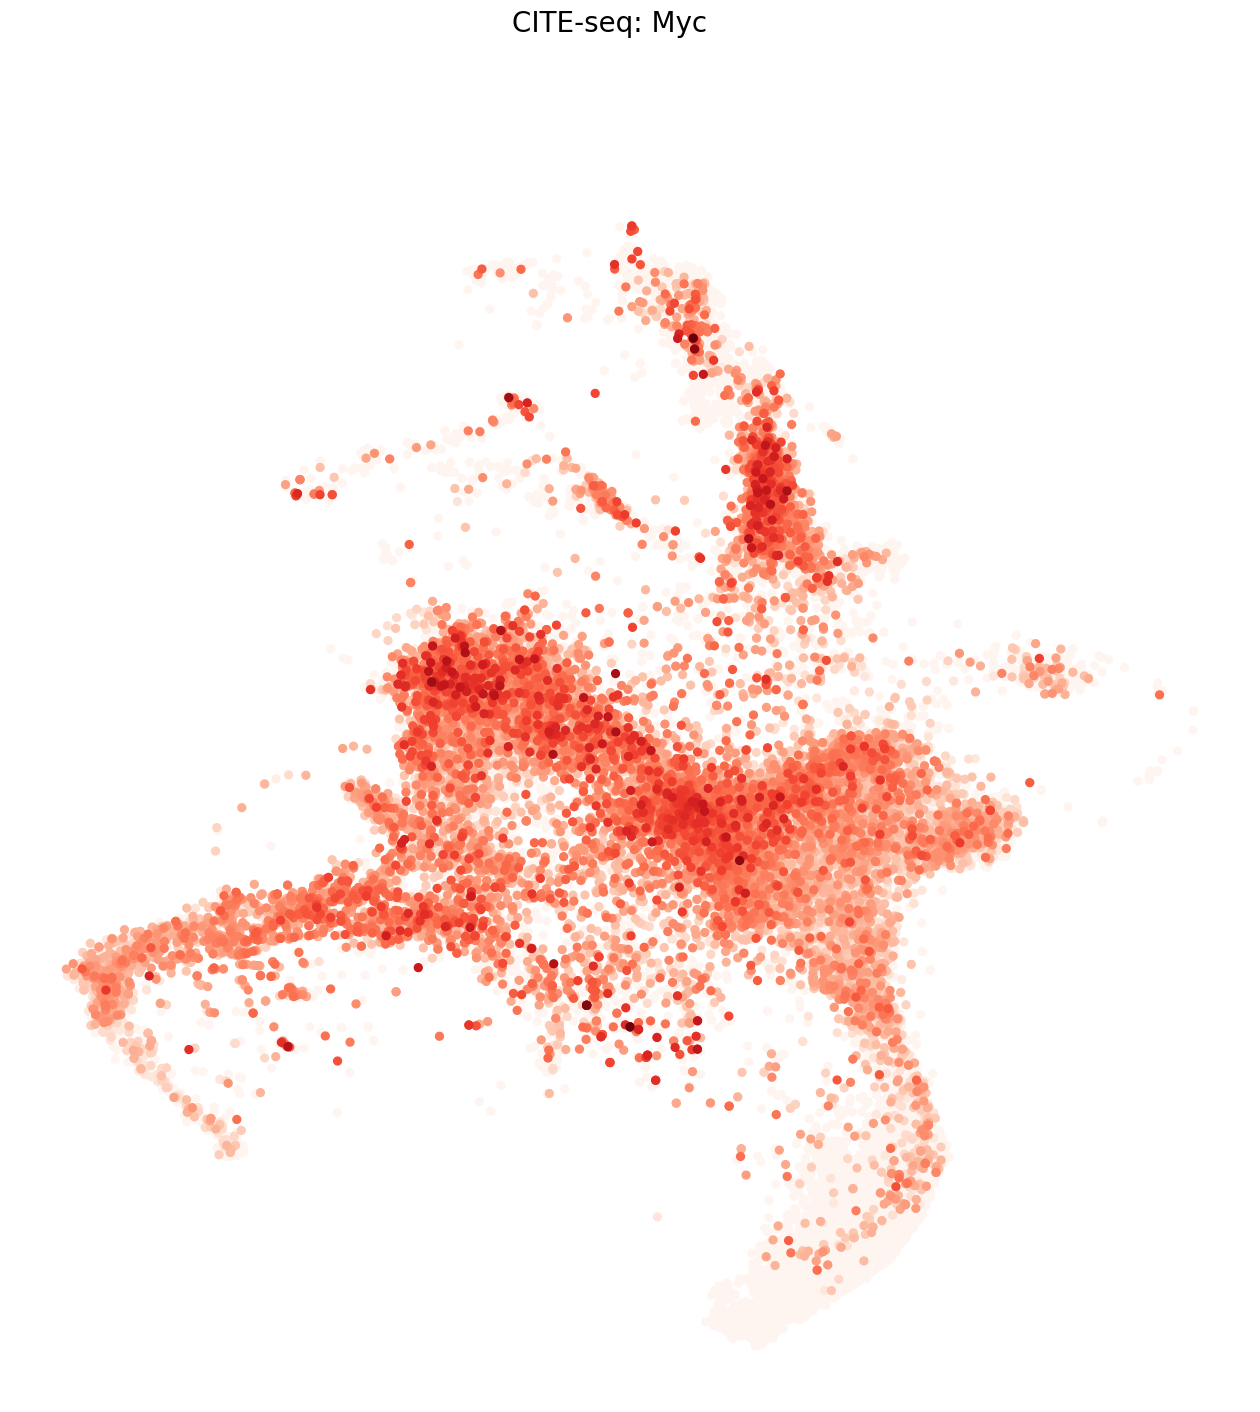

In [38]:
# # Myc-GFP
# helper_plot_marker_over_umap(\
#     marker_name="Myc-GFP", 
#     exp_vector=tmp_fcs[\
#         even_sampled_cells.values, 
#         "Myc-GFP"].X.toarray().reshape(-1), 
#     umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
#     umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
#     point_size=1,
#     plot_title="Infinity Flow: Myc-GFP", 
#     path_output=os.path.join(\
#         path_out_plots,
#         "InfinityFlow_Myc-GFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Myc", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Myc"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99999), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Myc", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Myc_over_umap.png"))

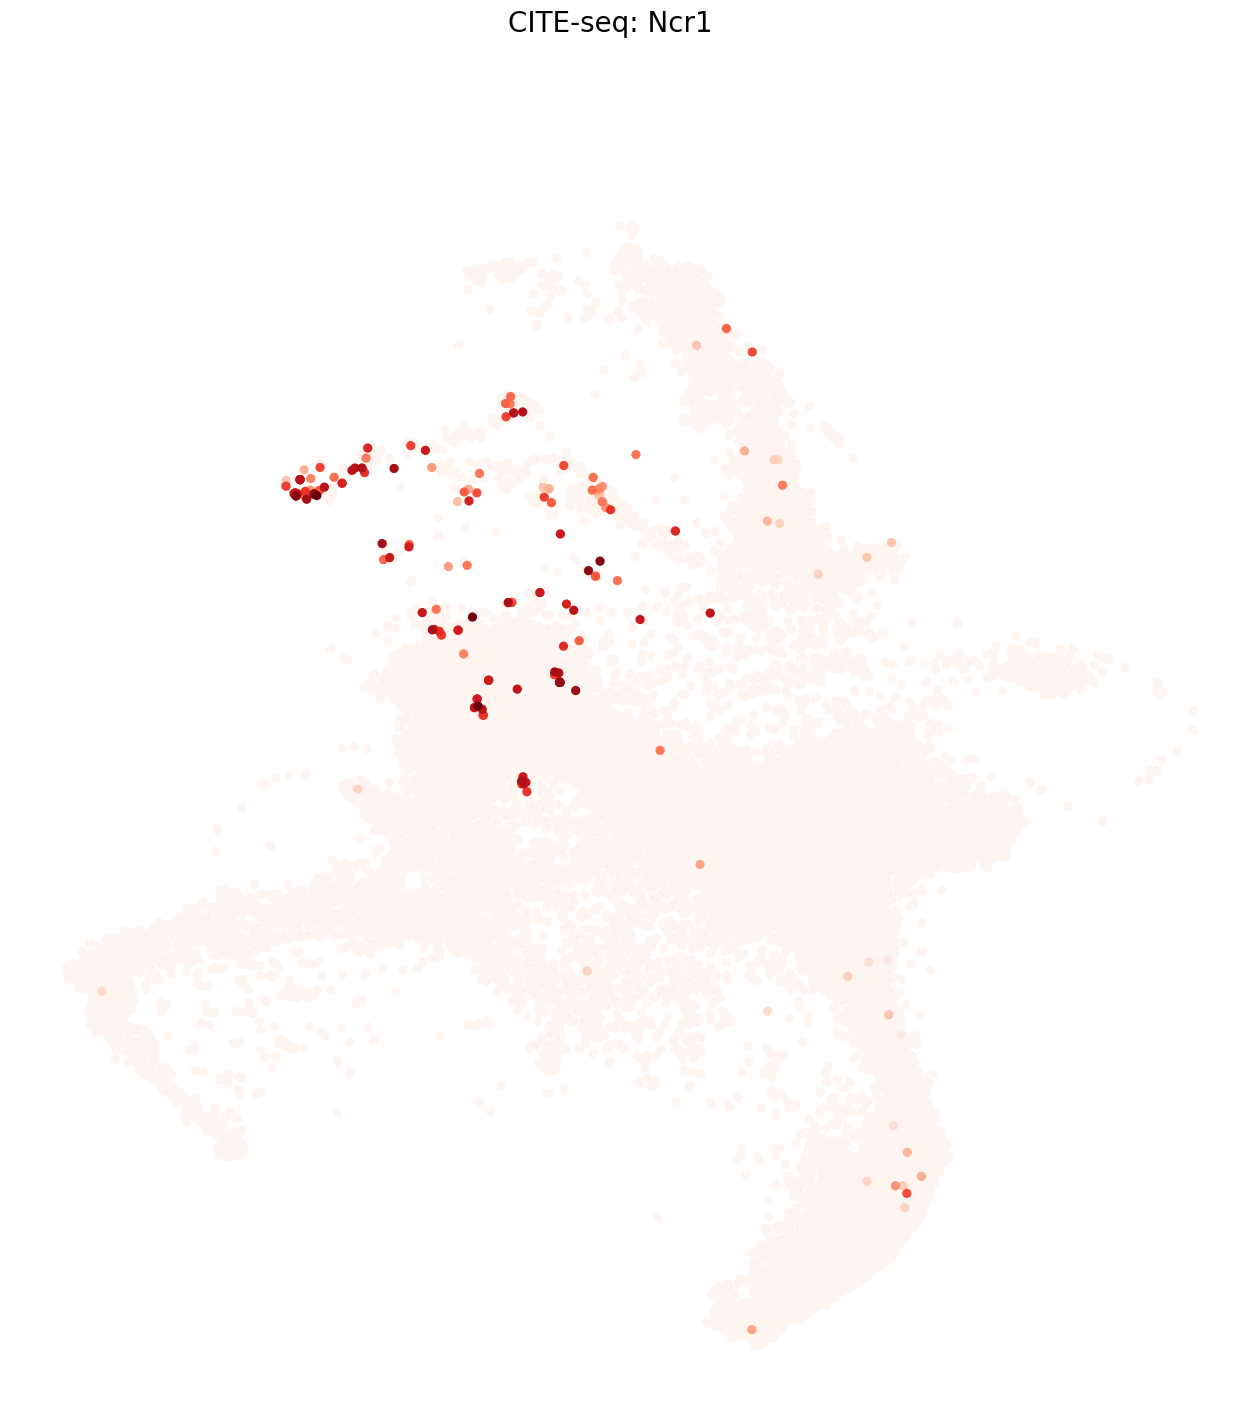

In [32]:
# Ncr1-GFP
# helper_plot_marker_over_umap(\
#     marker_name="Ncr1-GFP", 
#     exp_vector=tmp_fcs[\
#         even_sampled_cells.values, 
#         "Ncr1-GFP"].X.toarray().reshape(-1), 
#     umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
#     umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
#     point_size=1,
#     plot_title="Infinity Flow: Ncr1-GFP", 
#     path_output=os.path.join(\
#         path_out_plots,
#         "InfinityFlow_Ncr1-GFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Ncr1", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
            cite_groups.index.values, 
            "Ncr1"].X.toarray().reshape(-1),
        ptilemin=95, 
        ptilemax=99.999), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Ncr1", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Ncr1_over_umap.png"))

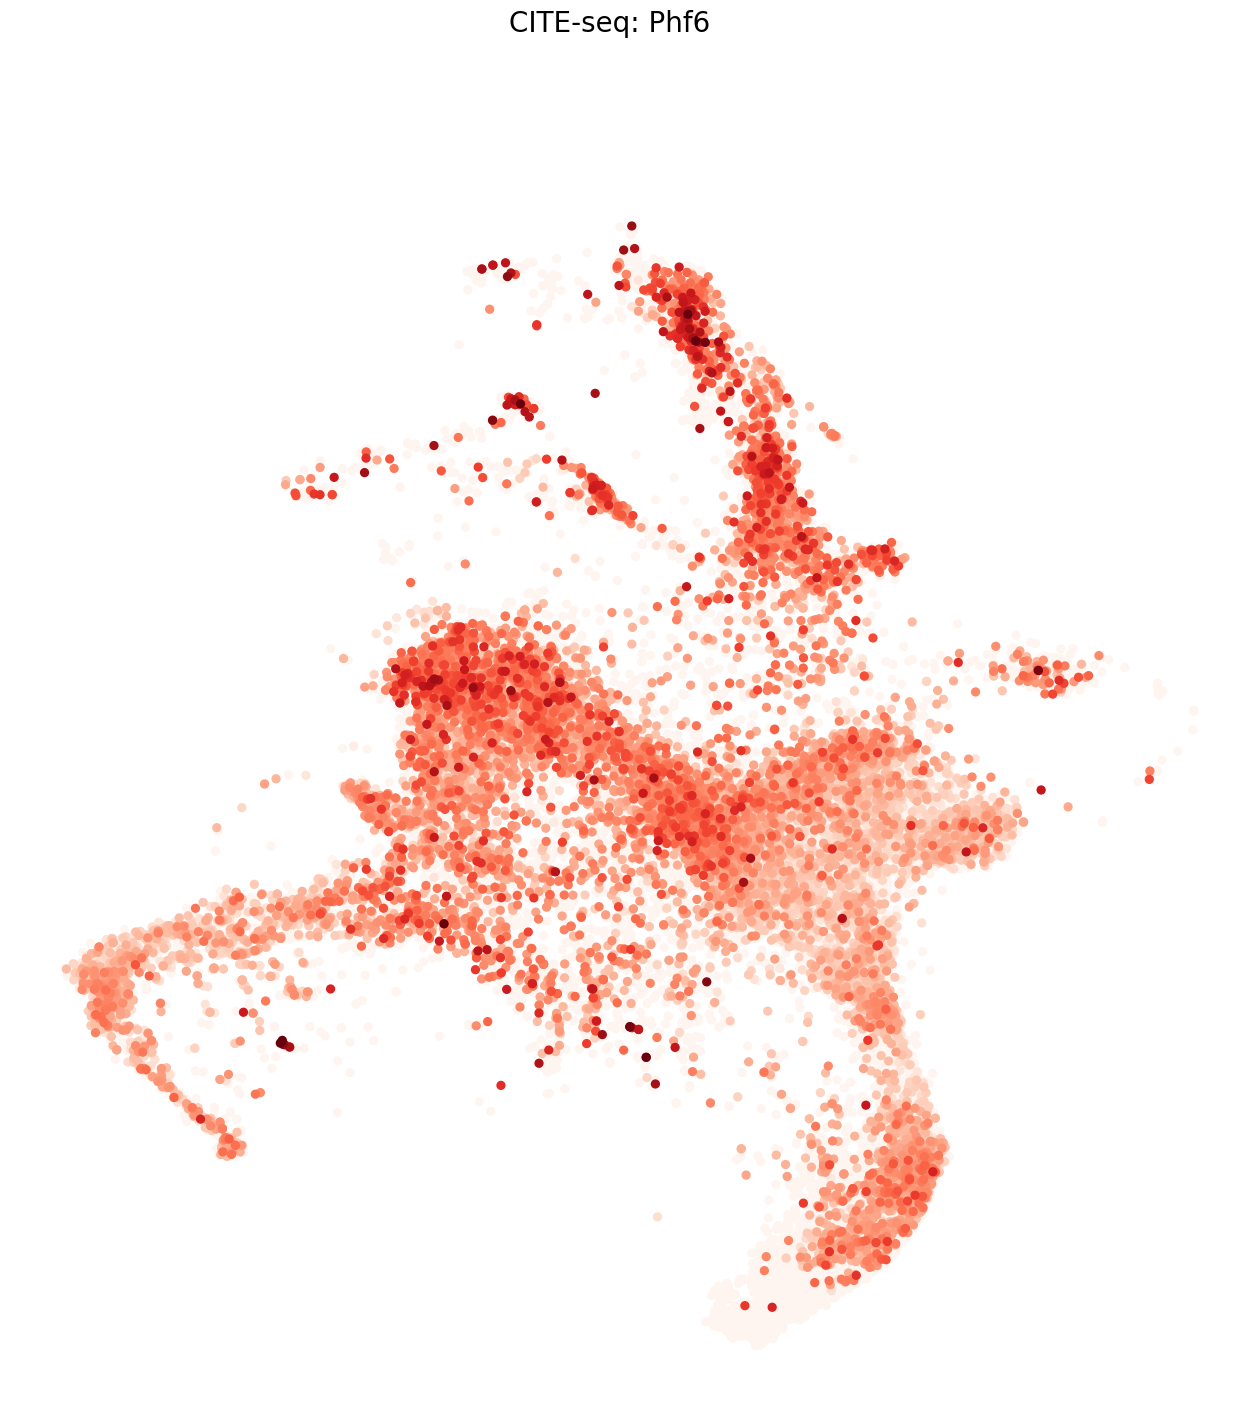

In [179]:
# Phf6_GFP
helper_plot_marker_over_umap(\
    marker_name="Phf6_GFP", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Phf6_GFP"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Phf6_GFP", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Phf6_GFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Phf6", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Phf6"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Phf6", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Phf6_over_umap.png"))

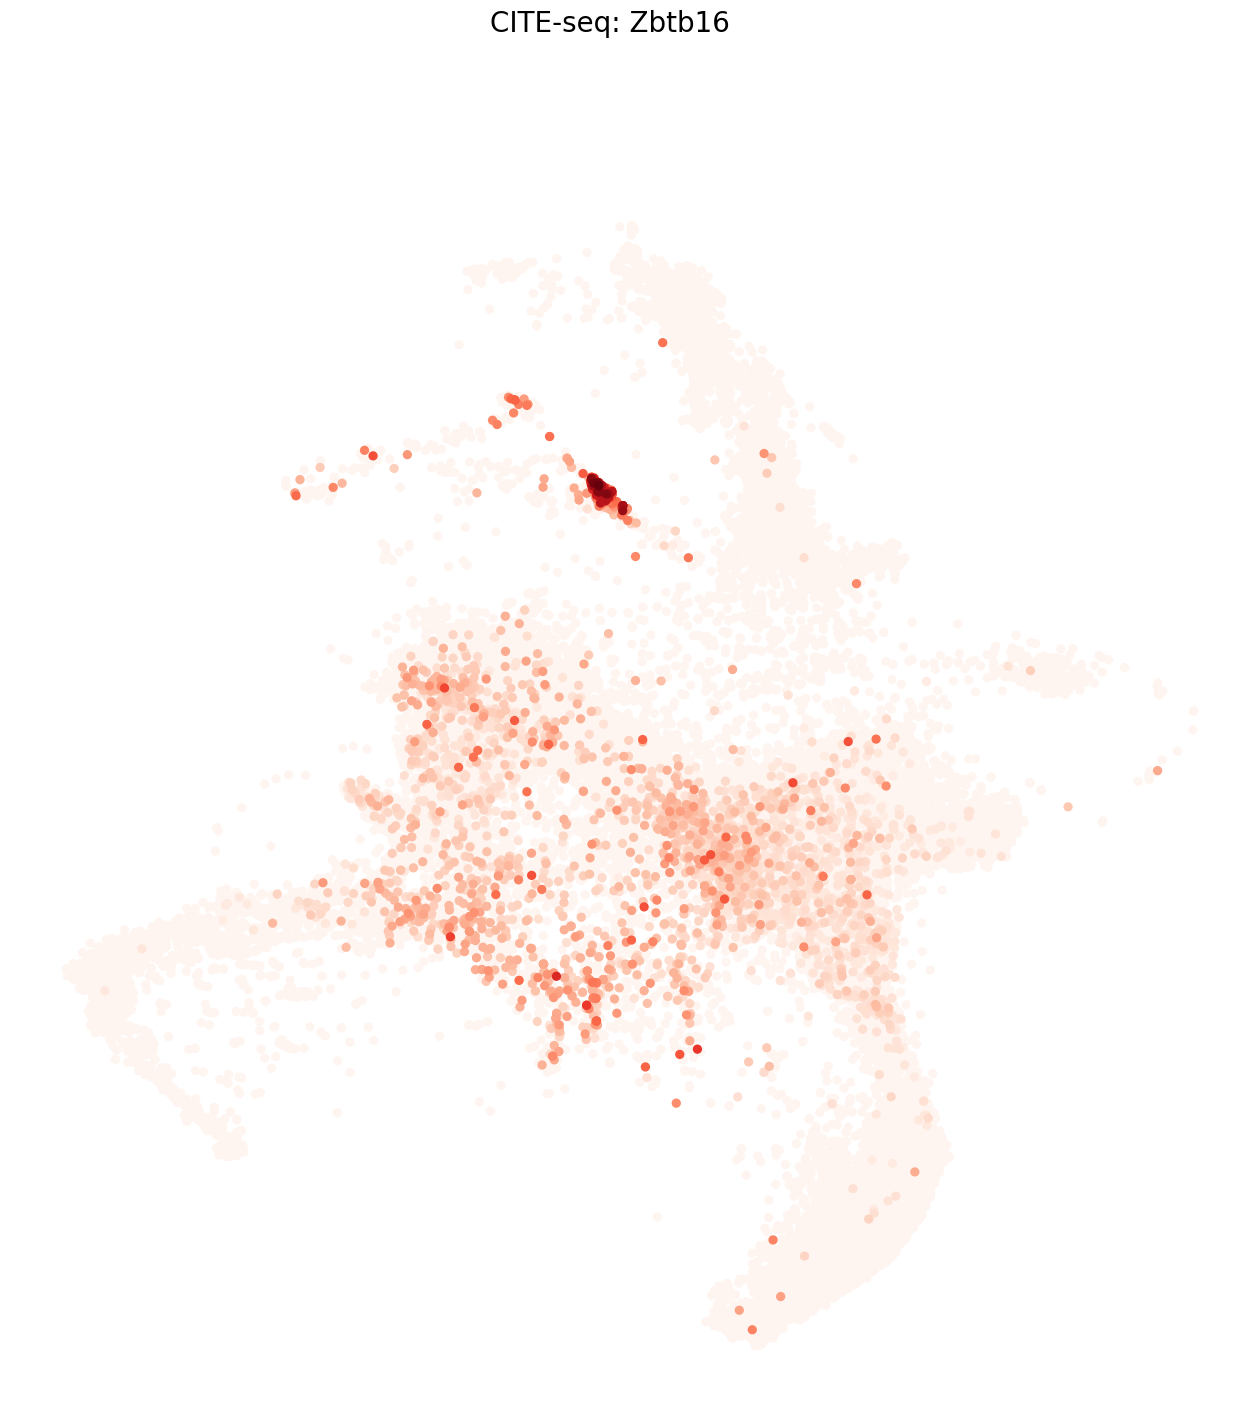

In [40]:
# # Plzf_GFP
# helper_plot_marker_over_umap(\
#     marker_name="Plzf_GFP", 
#     exp_vector=tmp_fcs[\
#         even_sampled_cells.values, 
#         "Plzf_GFP"].X.toarray().reshape(-1), 
#     umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
#     umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
#     point_size=1,
#     plot_title="Infinity Flow: Plzf_GFP", 
#     path_output=os.path.join(\
#         path_out_plots,
#         "InfinityFlow_Plzf_GFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Zbtb16", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
            cite_groups.index.values, 
            "Zbtb16"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99999), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Zbtb16", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Zbtb16_(Plzf)_over_umap.png"))

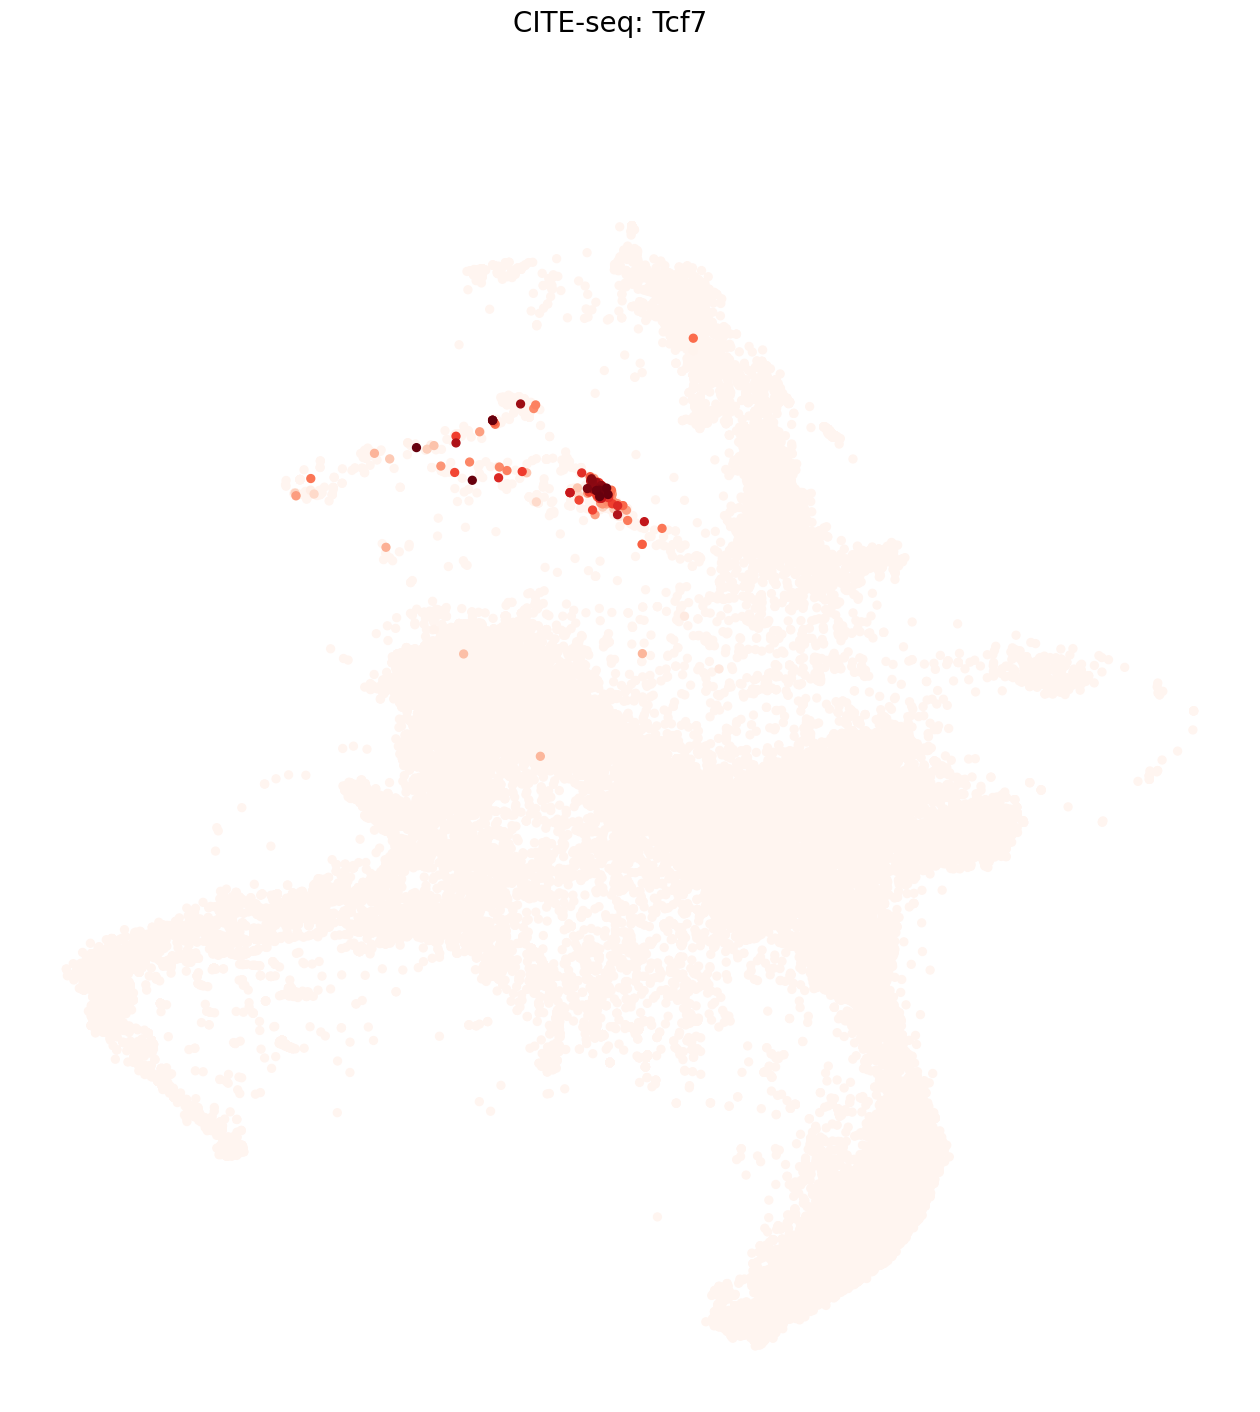

In [29]:

# Tcf7_GFP
# helper_plot_marker_over_umap(\
#     marker_name="Tcf7_GFP", 
#     exp_vector=tmp_fcs[\
#         even_sampled_cells.values, 
#         "Tcf7_GFP"].X.toarray().reshape(-1), 
#     umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
#     umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
#     point_size=1,
#     plot_title="Infinity Flow: Tcf7_GFP", 
#     path_output=os.path.join(\
#         path_out_plots,
#         "InfinityFlow_Tcf7_GFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Tcf7", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Tcf7"].X.toarray().reshape(-1),
        ptilemin=99.5, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Tcf7", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Tcf7_over_umap.png"))

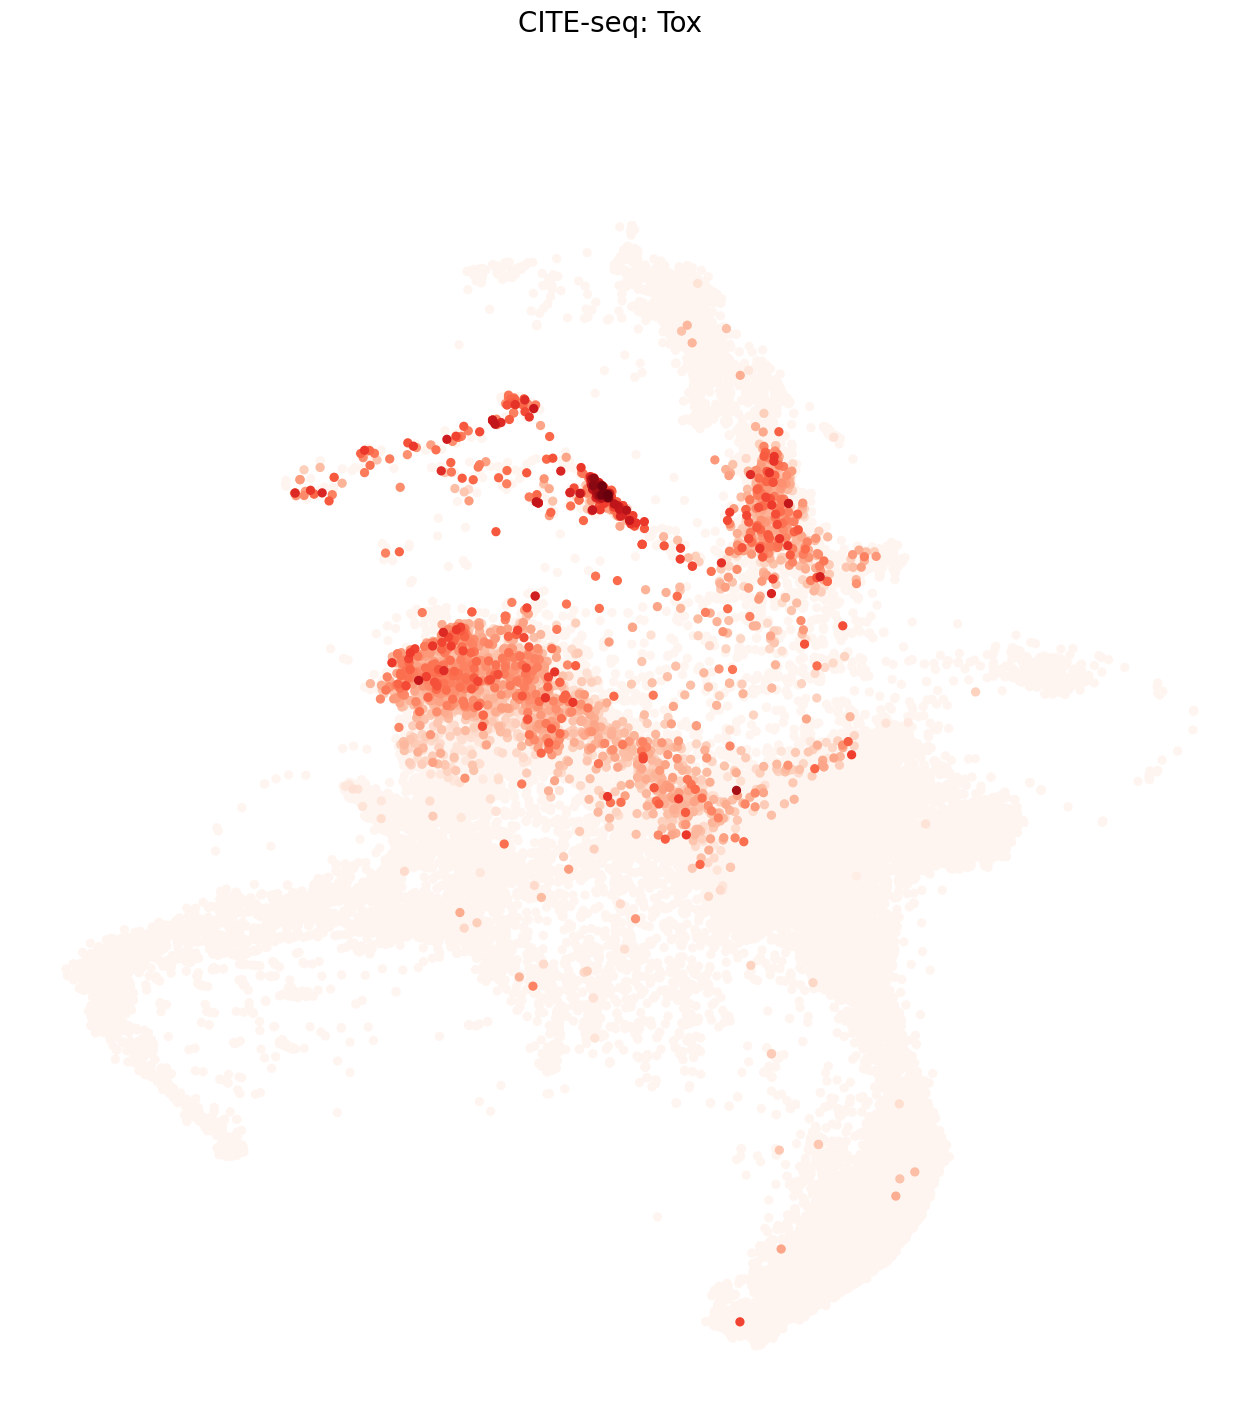

In [39]:
# Tox-tdTomato
helper_plot_marker_over_umap(\
    marker_name="Tox-tdTomato", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Tox-tdTomato"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Tox-tdTomato", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Tox-tdTomato_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Tox", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Tox"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.999999), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Tox", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Tox_over_umap.png"))

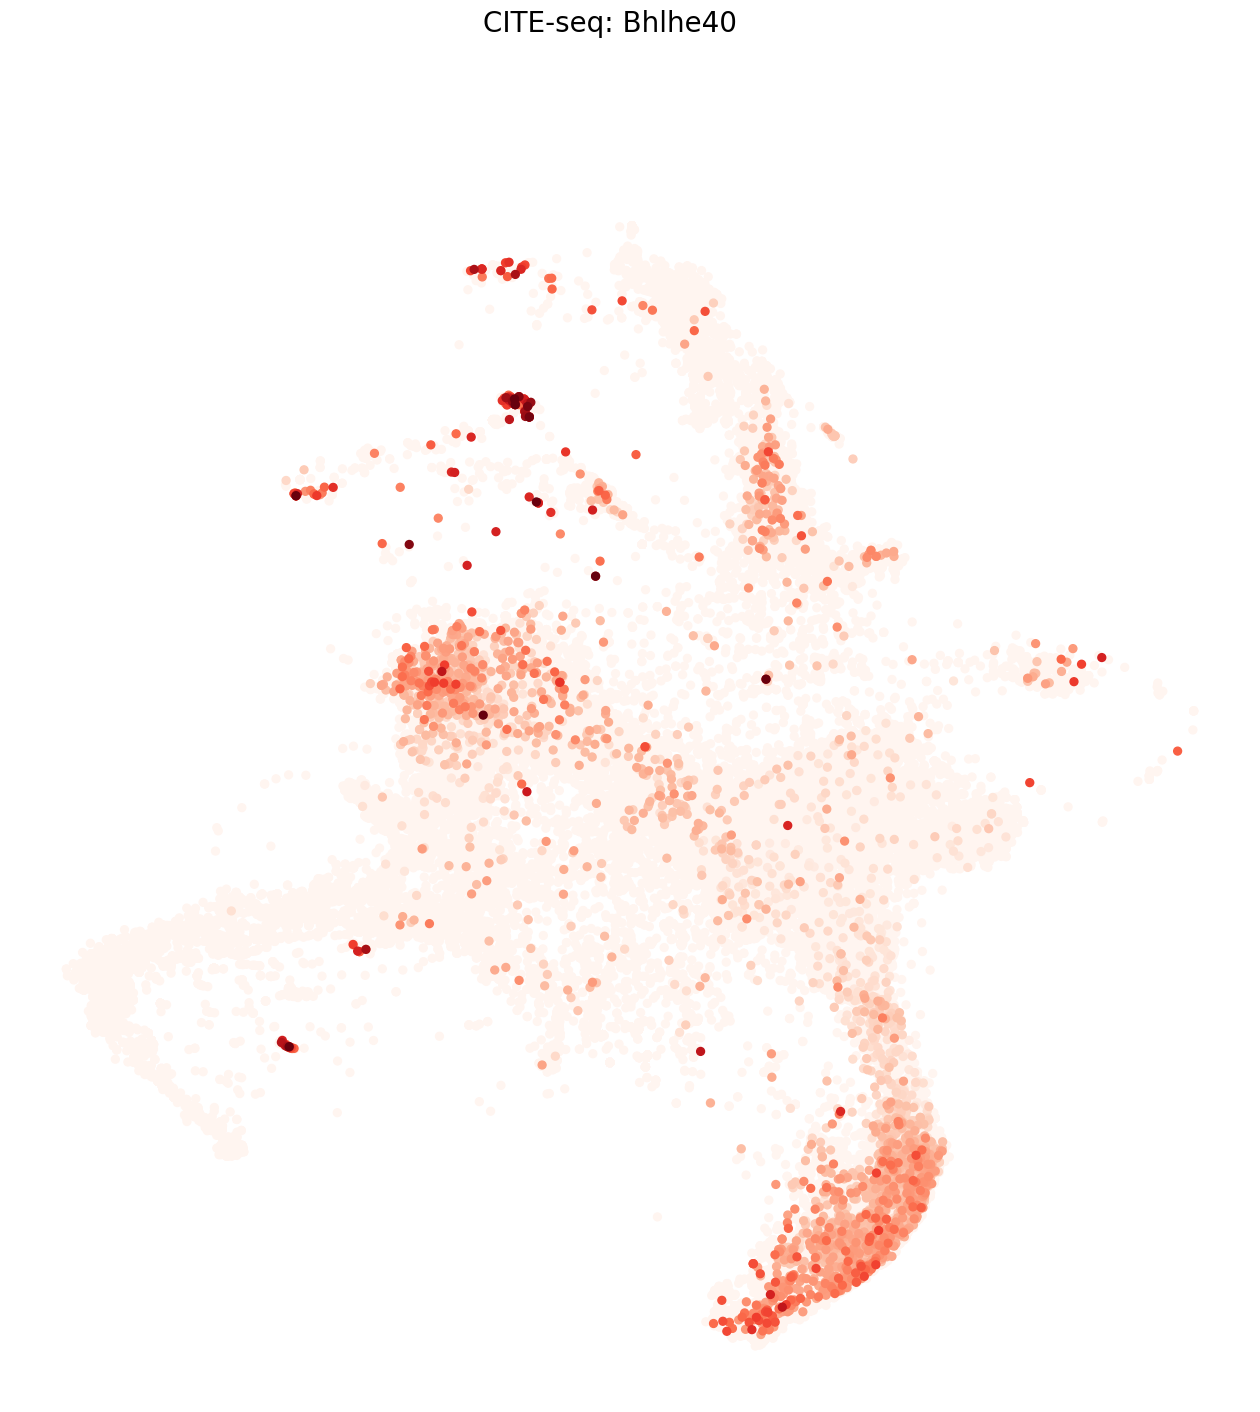

In [183]:
# Bhlhe40-GFP
helper_plot_marker_over_umap(\
    marker_name="Bhlhe40-GFP", 
    exp_vector=tmp_fcs[\
        even_sampled_cells.values, 
        "Bhlhe40-GFP"].X.toarray().reshape(-1), 
    umap_1=umap_anno.loc[even_sampled_cells.values,"umap-x"].values, 
    umap_2=umap_anno.loc[even_sampled_cells.values,"umap-y"].values, 
    point_size=1,
    plot_title="Infinity Flow: Bhlhe40-GFP", 
    path_output=os.path.join(\
        path_out_plots,
        "InfinityFlow_Bhlhe40-GFP_over_umap.png"))

helper_plot_marker_over_umap(\
    marker_name="Bhlhe40", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Bhlhe40"].X.toarray().reshape(-1),
        ptilemin=1, 
        ptilemax=99.99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Bhlhe40", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Bhlhe40_over_umap.png"))

In [190]:
# Build matrices for cite-seq and centroid nearest neighbors from inflow

cite_seq_df = pd.DataFrame(\
    adata_cite[\
        cite_groups.index.values, 
        ["Irf8", "Gfi1", "Spi1", "Myc", "Gata1", "Gata2",
        "Bhlhe40", "Tox", "Tcf7", "Zbtb16", "Phf6",
        "Ncr1"]].X.toarray(),
    index=cite_groups.index.values,
    columns=["Irf8", "Gfi1", "Spi1", "Myc", "Gata1", "Gata2",
        "Bhlhe40", "Tox", "Tcf7", "Zbtb16", "Phf6",
        "Ncr1"])

cite_seq_df

Irf8  Gfi1      Spi1       Myc  Gata1  \
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC  0.000000   0.0  0.000000  0.000000    0.0   
TTTGGTTTCGCCTATC-1.AS_CITE_HSC  0.000000   0.0  1.771094  0.000000    0.0   
GAGTTTGGTGCTGATT-1.AS_CITE_HSC  0.000000   0.0  1.910203  0.000000    0.0   
GCTACAAGTTAGAAAC-1.AS_CITE_HSC  0.000000   0.0  1.006829  1.006829    0.0   
TTACCGCGTATGCAAA-1.AS_CITE_HSC  0.000000   0.0  0.000000  0.000000    0.0   
...                                  ...   ...       ...       ...    ...   
TTGCGTCCAGTTAAAG-1.AS_CITE_HSC  2.358627   0.0  0.000000  0.000000    0.0   
AATGAAGGTTGCCGCA-1.AS_CITE_HSC  1.632249   0.0  1.632249  0.000000    0.0   
AAGACTCGTAATCAGA-1.AS_CITE_HSC  1.121669   0.0  0.667205  0.000000    0.0   
TCGGTCTAGACCATTC-1.AS_CITE_HSC  2.232956   0.0  0.000000  0.000000    0.0   
TACTTCATCCTATTGT-1.AS_CITE_HSC  3.632056   0.0  2.262852  0.000000    0.0   

                                   Gata2   Bhlhe40       Tox  Tcf7  Zbtb16  \
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC  1.306372  0.000000  0.000000   0.0     0.0   
TTTGGTTTCGCCTATC-1.AS_CITE_HSC  1.771094  0.000000  0.000000   0.0     0.0   
GAGTTTGGTGCTGATT-1.AS_CITE_HSC  0.000000  0.000000  1.910203   0.0     0.0   
GCTACAAGTTAGAAAC-1.AS_CITE_HSC  2.010231  0.000000  0.000000   0.0     0.0   
TTACCGCGTATGCAAA-1.AS_CITE_HSC  2.586366  0.000000  0.000000   0.0     0.0   
...                                  ...       ...       ...   ...     ...   
TTGCGTCCAGTTAAAG-1.AS_CITE_HSC  0.000000  0.000000  0.000000   0.0     0.0   
AATGAAGGTTGCCGCA-1.AS_CITE_HSC  0.000000  3.523536  0.000000   0.0     0.0   
AAGACTCGTAATCAGA-1.AS_CITE_HSC  0.000000  0.667205  0.000000   0.0     0.0   
TCGGTCTAGACCATTC-1.AS_CITE_HSC  0.000000  0.000000  0.000000   0.0     0.0   
TACTTCATCCTATTGT-1.AS_CITE_HSC  0.000000  0.000000  0.000000   0.0     0.0   

                                    Phf6  Ncr1  
TTGTTTGTCCGTGGTG-1.AS_CITE_HSC  0.000000   0.0  
TTTGGTTTCGCCTATC-1.AS_CITE_HSC  0.000000   0.0  
GAGTTTGGTGCTGATT-1.AS_CITE_HSC  2.704261   0.0  
GCTACAAGTTAGAAAC-1.AS_CITE_HSC  0.000000   0.0  
TTACCGCGTATGCAAA-1.AS_CITE_HSC  0.000000   0.0  
...                                  ...   ...  
TTGCGTCCAGTTAAAG-1.AS_CITE_HSC  0.000000   0.0  
AATGAAGGTTGCCGCA-1.AS_CITE_HSC  0.000000   0.0  
AAGACTCGTAATCAGA-1.AS_CITE_HSC  0.000000   0.0  
TCGGTCTAGACCATTC-1.AS_CITE_HSC  0.000000   0.0  
TACTTCATCCTATTGT-1.AS_CITE_HSC  0.000000   0.0  

[55403 rows x 12 columns]

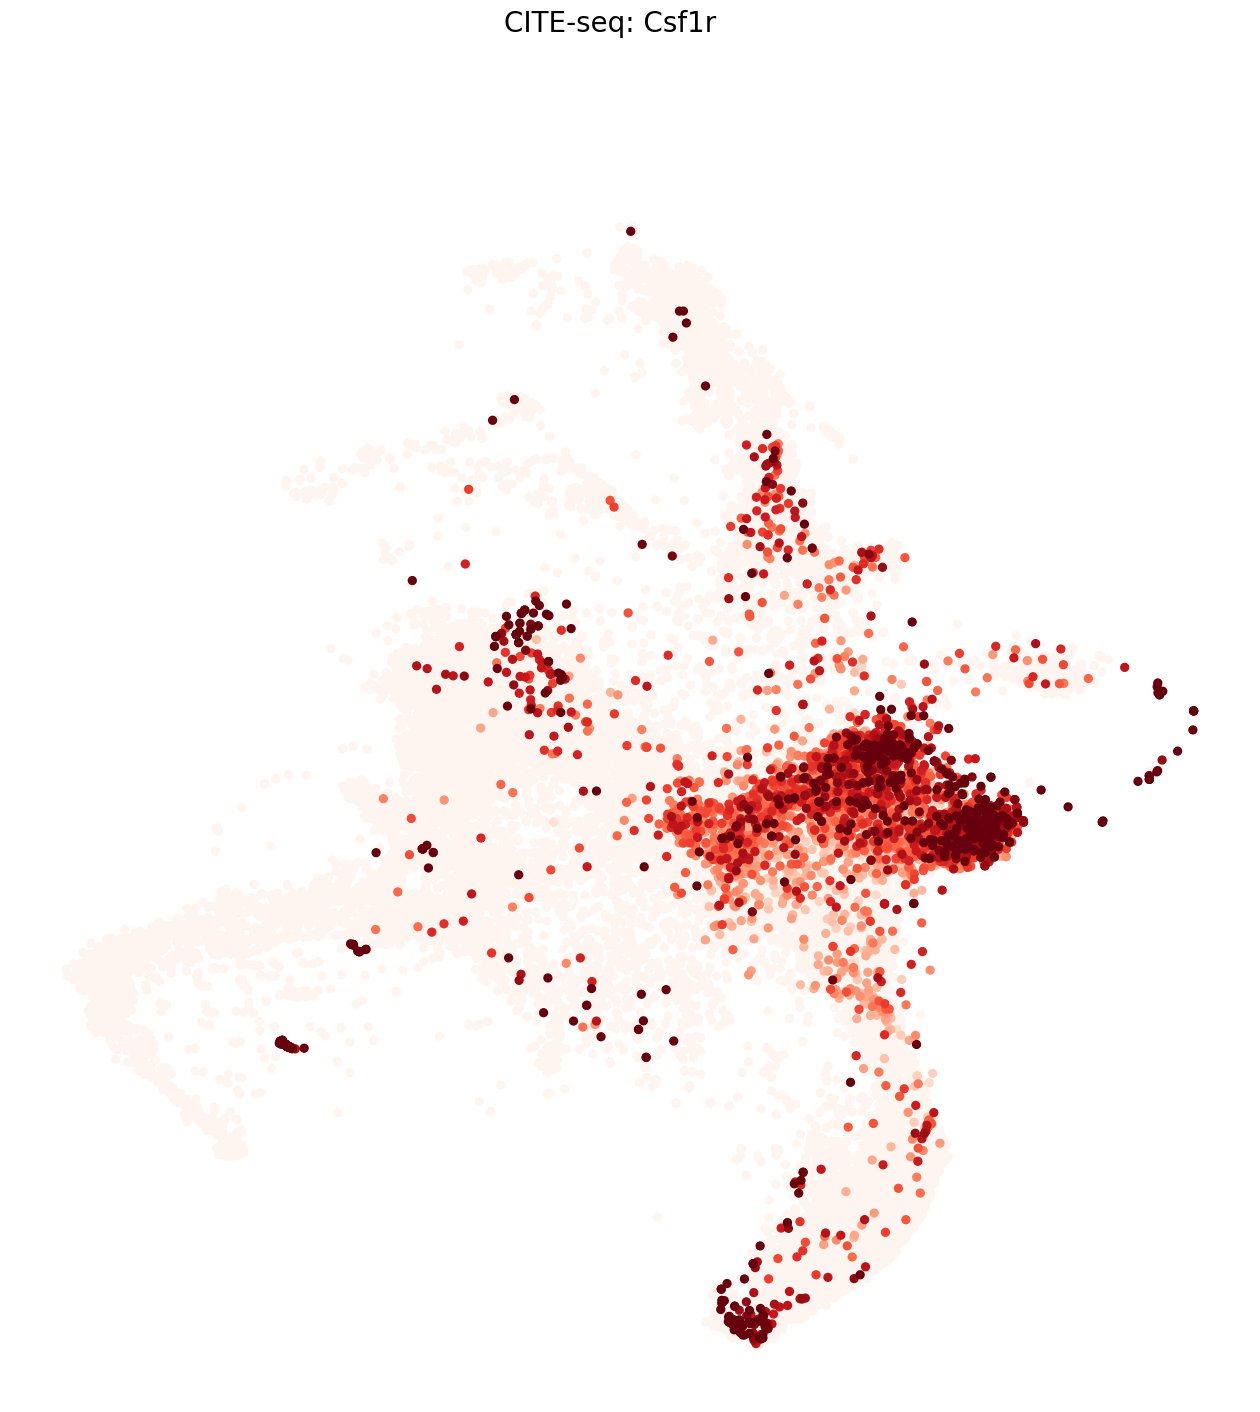

In [37]:
helper_plot_marker_over_umap(\
    marker_name="Csf1r", 
    exp_vector=normalize_signal_for_plotting_mrna_counts(adata_cite[\
        cite_groups.index.values, 
        "Csf1r"].X.toarray().reshape(-1),
        ptilemin=5, 
        ptilemax=99), 
    umap_1=cite_groups.loc[cite_groups.index.values,"umap-x"].values, 
    umap_2=cite_groups.loc[cite_groups.index.values,"umap-y"].values, 
    point_size=32,
    plot_title="CITE-seq: Csf1r", 
    path_output=os.path.join(\
        path_out_plots,
        "CITE-seq_Csf1r_over_umap.png"))

In [191]:
ordered_inflow_features = [\
    "GFP-A", 
    "Gfi1-tdTomato", 
    "Pu.1-YFP", 
    "Myc-GFP",
    "Gata1-mCherry", 
    "Gata2-Venus",
    "Bhlhe40-GFP",
    "Tox-tdTomato",
    "Tcf7_GFP",
    "Plzf_GFP",
    "Phf6_GFP",
    "Ncr1-GFP"]
inflow_nn_centroid_df = pd.DataFrame(\
    [list(tmp_fcs[\
        cite_nn_to_inflow.loc[i, "nn_indices"].split("|"),
        ordered_inflow_features].X.toarray().mean(axis=0)) for i in \
            cite_groups.index.values],
    index=cite_groups.index.values,
    columns=[\
        "InfinityFlow:Irf8",
        "InfinityFlow:Gfi1",
        "InfinityFlow:Spi1",
        "InfinityFlow:Myc-GFP",
        "InfinityFlow:Gata1",
        "InfinityFlow:Gata2",
        "InfinityFlow:Bhlhe40-GFP",
        "InfinityFlow:Tox-tdTomato",
        "InfinityFlow:Tcf7_GFP",
        "InfinityFlow:Plzf_GFP",
        "InfinityFlow:Phf6_GFP",
        "InfinityFlow:Ncr1-GFP"])


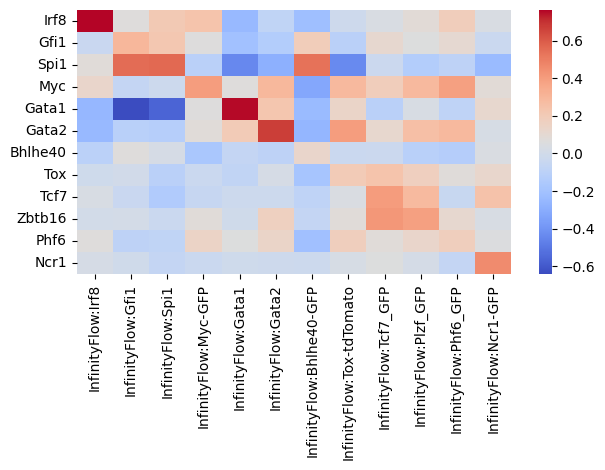

In [192]:
sns.heatmap(pearson_corr_df_to_df(cite_seq_df, inflow_nn_centroid_df), cmap="coolwarm", annot=False)
plt.tight_layout()
plt.savefig("output/plots_for_publication/cite_to_infinityflow_4nns_pearson_corr_heatmap_full.pdf")

In [189]:
cite_seq_df.columns.values

array(['Irf8', 'Gfi1', 'Spi1', 'Myc', 'Gata1', 'Gata2', 'Bhlhe40', 'Tox',
       'Tcf7', 'Zbtb16', 'Phf6', 'Ncr1', 'Myc'], dtype=object)

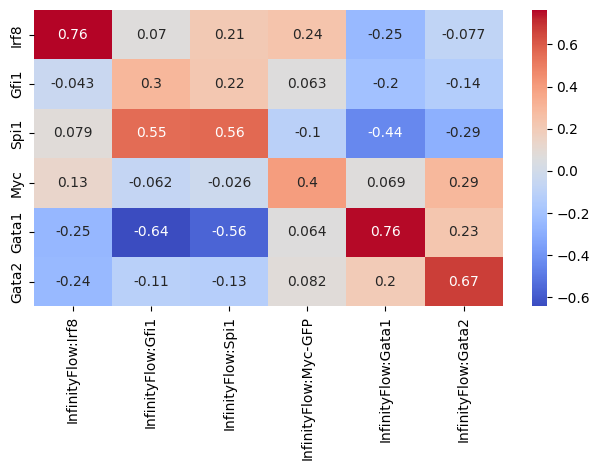

In [194]:
# Filter to best
sns.heatmap(pearson_corr_df_to_df(\
        cite_seq_df[[\
            "Irf8",
            "Gfi1",
            "Spi1",
            "Myc",
            "Gata1",
            "Gata2"]], 
        inflow_nn_centroid_df[[\
            "InfinityFlow:Irf8",
            "InfinityFlow:Gfi1",
            "InfinityFlow:Spi1",
            "InfinityFlow:Myc-GFP",
            "InfinityFlow:Gata1",
            "InfinityFlow:Gata2"]]), 
    cmap="coolwarm", annot=True)
plt.tight_layout()
plt.savefig("output/plots_for_publication/cite_to_infinityflow_4nns_pearson_corr_heatmap_filtered.pdf")

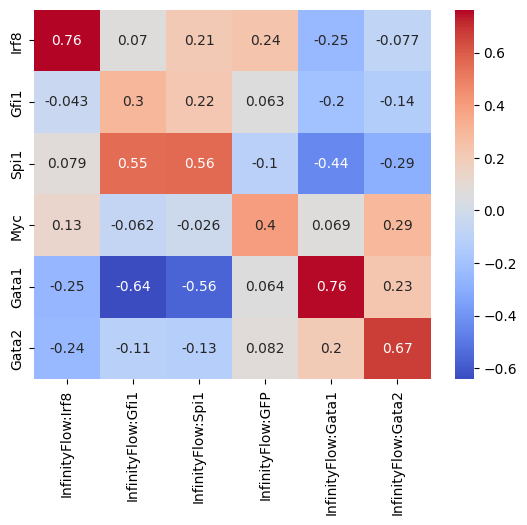

In [157]:
# sns.heatmap(pearson_corr_df_to_df(cite_seq_df, inflow_nn_centroid_df), cmap="coolwarm", annot=True)
# plt.savefig("output/plots_for_publication/cite_to_infinityflow_4nns_pearson_corr_heatmap.pdf")